# **EDA On NYC Yellow Taxi Data**

## Objective
Learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City.

Understand why EDA is an important step in the process of DS & ML.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are asked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

### Import Libraries

In [1]:
# Import warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the libraries you will be using for analysis

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("Current numpy version:", np.__version__)
print("Current pandas version:", pd.__version__)
print("Current matplotlib version:", plt.matplotlib.__version__)
print("Current seaborn version:", sns.__version__)

Current numpy version: 1.26.4
Current pandas version: 2.2.2
Current matplotlib version: 3.10.0
Current seaborn version: 0.13.2


### **1.1** Load the dataset

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

from pathlib import Path

# Try locating the trip_records directory from cwd upward
for cwdir in [Path.cwd(), Path.cwd().parent, *Path.cwd().parents]:
    dir_path = cwdir / "data" / "trip_records"
    if dir_path.exists():
        data_dir = dir_path
        break
else:
    raise FileNotFoundError("'trip_records' not found under current working directory.")

# You need to download trip records(.parquet file of yellow taxi) from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
parquet_file_name = "2023-1.parquet"
parquet_file_path = data_dir / parquet_file_name

print("Now look for file:", parquet_file_path.resolve())
if not parquet_file_path.exists():
    print(f"File '{parquet_file_name}' not found.")
    print("Directory contents:")
    for c in sorted(data_dir.iterdir()):
        print(" -", c.name)
else:
    df = pd.read_parquet(parquet_file_path)
    print(f"Loaded {parquet_file_name} shape={df.shape}")
    df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

#### NOTE:
# Move this .ipynb file to the directory that contains the 12 parquet files to run the sampling code below successfully.


In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# ===============================
# Sampling strategy: 0.008% per date-hour from each month's parquet file
# This code reads each monthly parquet file one by one, and for
# each date in the month it iterates over 24 hours and randomly samples
# a fraction of trips for that date-hour. All sampled rows are concatenated
# into a single df which represents the full year's sampled data.
# ===============================

# cwd should contains the 12 parquet files
cwd = Path.cwd()
print("Current working directory:", Path.cwd())

for base in [Path.cwd(), Path.cwd().parent, *Path.cwd().parents]:
    candidate = base / "Datasets and Dictionary-NYC" / "Datasets and Dictionary" / "trip_records"
    if candidate.exists():
        data_dir = candidate
        break
else:
    raise FileNotFoundError("Could not find 'trip_records' under any parent of CWD.")

os.chdir(data_dir)

# Create a list of all the twelve files to read
file_list = sorted([f for f in os.listdir() if f.lower().endswith('.parquet')])

# Initialise an empty dataframe that will accumulate sampled data from all months
df = pd.DataFrame()

# Define sample fraction and random state which we will use later in this assignment
SAMPLE_FRAC = 0.008
RANDOM_STATE = 42

# Iterate through the list of files and sample one by one
for file_name in file_list:
    try:
        # File path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file (full file; no column filtering)
        month_df = pd.read_parquet(file_path)

        # Ensure pickup datetime is parsed correctly
        month_df['tpep_pickup_datetime'] = pd.to_datetime(
            month_df['tpep_pickup_datetime'], errors='coerce'
        )

        # Drop rows where pickup datetime could not be parsed
        month_df = month_df.dropna(subset=['tpep_pickup_datetime'])

        # Derive date and hour from pickup datetime
        month_df['pickup_date'] = month_df['tpep_pickup_datetime'].dt.date
        month_df['pickup_hour'] = month_df['tpep_pickup_datetime'].dt.hour

        # We will store the sampled data for the current month here
        # Sampling within each (date, hour) group
        sampled_month = (
            month_df
            .groupby(['pickup_date', 'pickup_hour'], group_keys=False)
            .apply(lambda g: g.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
                             if len(g) > 0 else g)
        )

        # Concatenate the sampled data of this month to the yearly dataframe
        df = pd.concat([df, sampled_month], ignore_index=True)

        print(f"{file_name}: original rows={len(month_df):,} sampled rows={len(sampled_month):,}")

        # (Optional) Free intermediate DataFrames
        del month_df, sampled_month

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Final yearly combined sampled dataframe
print("Final sampled yearly shape:", df.shape)

df.info()

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [8]:
# Store the df in csv/parquet

combined_data_file = "nyc_taxi_2023_sampled"
df.to_parquet(f"{combined_data_file}.parquet", index=False, compression="snappy")
df.to_csv(f"{combined_data_file}.csv", index=False)

print("Saved files:")
print(f" - {combined_data_file}.parquet")
print(f" - {combined_data_file}.csv")


Saved files:
 - nyc_taxi_2023_sampled.parquet
 - nyc_taxi_2023_sampled.csv


## **2** Data Cleaning
<br>

Now we can load the new data directly.

In [9]:
# Load the new data file

df = pd.read_parquet(combined_data_file + ".parquet")

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour,Airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,...,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0,NaN
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,...,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0,NaN
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,...,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0,NaN
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,...,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0,NaN
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,...,0.5,5.93,0.0,1.0,35.57,NaN,NaN,2023-01-01,0,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303838 entries, 0 to 303837
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               303838 non-null  int64         
 1   tpep_pickup_datetime   303838 non-null  datetime64[us]
 2   tpep_dropoff_datetime  303838 non-null  datetime64[us]
 3   passenger_count        293620 non-null  float64       
 4   trip_distance          303838 non-null  float64       
 5   RatecodeID             293620 non-null  float64       
 6   store_and_fwd_flag     293620 non-null  object        
 7   PULocationID           303838 non-null  int64         
 8   DOLocationID           303838 non-null  int64         
 9   payment_type           303838 non-null  int64         
 10  fare_amount            303838 non-null  float64       
 11  extra                  303838 non-null  float64       
 12  mta_tax                303838 non-null  floa

#### **2.1** Fixing Columns

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** 

Fix the index and drop unnecessary columns

In [12]:
# Fix the index and drop any columns that are not needed

print("Starting shape (df):", getattr(df, "shape", None))

# Reset index on a working copy
df_clean = df.reset_index(drop=True)
print("After reset_index (df_clean):", df_clean.shape)
df = df_clean

## NOTE:'pickup_date', 'pickup_hour' are derived columns which I will use in further assignment so not dropping them here.

Starting shape (df): (303838, 22)
After reset_index (df_clean): (303838, 22)


**2.1.2** 
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [13]:
# Combine the two airport fee columns

fee_cols = [c for c in df.columns if c.lower().startswith("airport_fee")]

if fee_cols:
    # Create unified column taking first non-null value across variants; fill remaining NaN with 0
    df["airport_fee"] = pd.concat([df[c] for c in fee_cols], axis=1).bfill(axis=1).iloc[:, 0].fillna(0)
    # Drop original duplicates except the unified one
    for c in fee_cols:
        if c != "airport_fee":
            df.drop(columns=c, inplace=True, errors="ignore")

print("Shape after combining columns:", df.shape)

Shape after combining columns: (303838, 21)


**2.1.3** 
Fix columns with negative (monetary) values

In [14]:
# check where values of fare amount are negative

neg_fares = df[df['fare_amount'] < 0].copy()

total_rows = len(df)
neg_rows = len(neg_fares)
print(f"Total rows: {total_rows:,}")
print(f"Negative fare rows: {neg_rows:,}")

if neg_rows:
    print("Distinct negative fare values:", sorted(neg_fares['fare_amount'].unique()))
    display(neg_fares.head(20))
    print("Summary stats (negative fares):")
    print(neg_fares['fare_amount'].describe())
else:
    print("No negative fare_amount values found.")

Total rows: 303,838
Negative fare rows: 0
No negative fare_amount values found.


Did you notice something different in the `RatecodeID` column for above records?

In [15]:
# Analyse RatecodeID for the negative fare amounts

neg_fares = df[df['fare_amount'] < 0].copy()
print(f"Negative fare rows: {len(neg_fares)}")

if neg_fares.empty:
    print("No negative fare_amount rows found.")
else:
    # Frequency of RatecodeID among negative fares
    print("RatecodeID counts (negative fares):")
    print(neg_fares['RatecodeID'].value_counts(dropna=False))

Negative fare rows: 0
No negative fare_amount rows found.


In [16]:
# Find which columns have negative values

num_cols = df.select_dtypes(include='number').columns
neg_info = []
for col in num_cols:
    neg_mask = df[col] < 0
    if neg_mask.any():
        neg_vals = df.loc[neg_mask, col]
        neg_info.append({
            'column': col,
            'neg_count': neg_mask.sum(),
            'neg_pct': round(neg_mask.mean()*100, 6),
            'min_neg': neg_vals.min(),
            'max_neg': neg_vals.max(),
            'distinct_neg_values_sample': sorted(neg_vals.unique())[:10]
        })

if not neg_info:
    print("No numeric columns contain negative values.")
else:
    neg_df = pd.DataFrame(neg_info).sort_values('neg_count', ascending=False)
    print("Columns with negative values (top rows):")
    display(neg_df)

Columns with negative values (top rows):


,column,neg_count,neg_pct,min_neg,max_neg,distinct_neg_values_sample
1,mta_tax,11,0.003620,-0.50,-0.50,[-0.5]
2,improvement_surcharge,11,0.003620,-1.00,-1.00,[-1.0]
3,total_amount,11,0.003620,-4.00,-1.50,"[-4.0, -3.25, -1.5]"
4,congestion_surcharge,6,0.001975,-2.50,-2.50,[-2.5]
5,airport_fee,2,0.000658,-1.75,-1.75,[-1.75]
0,extra,1,0.000329,-2.50,-2.50,[-2.5]


In [17]:
# fix these negative values

# For Columns mta_tax, improvement_surcharge, total_amount, congestion_surcharge, extra replace negative values with 0

print("\nBefore df shape:", df.shape)

cols = ['mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'extra']

for c in cols:
    s = pd.to_numeric(df[c], errors='coerce')
    neg = s < 0
    # Replace negative with 0
    if neg.any():
        df.loc[neg, c] = 0

print("\nAfter df shape:", df.shape)


Before df shape: (303838, 21)

After df shape: (303838, 21)


### **2.2** Handling Missing Values

**2.2.1**  
Find the proportion of missing values in each column




In [18]:
# Find the proportion of missing values in each column

total = len(df)

missing_counts = df.isna().sum()

if total > 0:
    missing_pct = (missing_counts / total * 100).round(4)
else:
    missing_pct = pd.Series(0.0, index=missing_counts.index)

summary = pd.DataFrame({ 'missing_pct': missing_pct }).sort_values('missing_pct', ascending=False)

print("\nproportion of missing values in each column:")
display(summary)


proportion of missing values in each column:


,missing_pct
passenger_count,3.363
RatecodeID,3.363
store_and_fwd_flag,3.363
congestion_surcharge,3.363
VendorID,0.000
mta_tax,0.000
pickup_date,0.000
airport_fee,0.000
total_amount,0.000
improvement_surcharge,0.000


**2.2.2**  
Handling missing values in `passenger_count`

In [19]:
# Display the rows with null values
df[df.isnull().any(axis=1)]

# Impute NaN values in 'passenger_count'

# impute with mode (most frequent value)
df.fillna({'passenger_count': df['passenger_count'].mode()[0]}, inplace=True)

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  
Handle missing values in `RatecodeID`

In [20]:
# Fix missing values in 'RatecodeID'

# impute with mode (most frequent value)
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode()[0])

**2.2.4**  
Impute NaN in `congestion_surcharge`

In [21]:
# handle null values in congestion_surcharge

# impute with median value
df['congestion_surcharge'].fillna(df['congestion_surcharge'].median(), inplace=True)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [22]:
# Handle any remaining missing values

# Summary of missing values
cols = df.columns.tolist()
rows = []
n = len(df)
for c in cols:
    ser = df[c]
    miss = ser.isna().sum()
    pct = miss / n * 100
    dtype = ser.dtype
    rows.append((c, dtype, round(pct,3)))
final = pd.DataFrame(rows, columns=['column','dtype','pct_missing'])
final = final.sort_values('pct_missing', ascending=False)
display(final[final['pct_missing']>0].head(5))

,column,dtype,pct_missing
6,store_and_fwd_flag,object,3.363


In [23]:
# Impute missing values in 'store_and_fwd_flag' with mode (most frequent value)

df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0], inplace=True)

### **2.3** Handling Outliers

Before we start fixing outliers, let's perform outlier analysis.

In [24]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
count,303838.000000,303838,303838,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.000000,303838.00000
mean,1.733753,2023-07-02 21:15:52.503995,2023-07-02 21:33:12.146364,1.354600,3.557967,1.629253,165.255607,163.922123,1.164614,20.279718,1.586429,0.495346,3.543840,0.590507,0.999009,29.332983,2.315165,0.137246,14.27097
min,1.000000,2023-01-01 00:04:34,2023-01-01 00:09:40,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.750000,0.00000
25%,1.000000,2023-04-02 16:48:14.500000,2023-04-02 17:12:57,1.000000,1.050000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,0.000000,11.00000
50%,2.000000,2023-06-27 16:23:18,2023-06-27 16:44:05.500000,1.000000,1.800000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.840000,0.000000,1.000000,21.000000,2.500000,0.000000,15.00000
75%,2.000000,2023-10-06 21:11:10.250000,2023-10-06 21:26:23.250000,1.000000,3.400000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.420000,0.000000,1.000000,30.800000,2.500000,0.000000,19.00000
max,6.000000,2023-12-31 23:54:03,2024-01-01 20:14:57,9.000000,22528.820000,99.000000,265.000000,265.000000,4.000000,143163.450000,14.250000,0.800000,150.290000,143.000000,1.000000,143167.450000,2.500000,1.750000,23.00000
std,0.447472,NaN,NaN,0.878099,45.452973,7.376361,64.050944,69.794111,0.507148,260.321623,1.823916,0.048086,4.045745,2.172670,0.029120,260.669706,0.654160,0.456180,5.80522


Numeric columns to be analyzed: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'pickup_hour']
Plotting distributions for top columns: ['passenger_count', 'payment_type', 'trip_distance', 'total_amount', 'fare_amount', 'airport_fee']


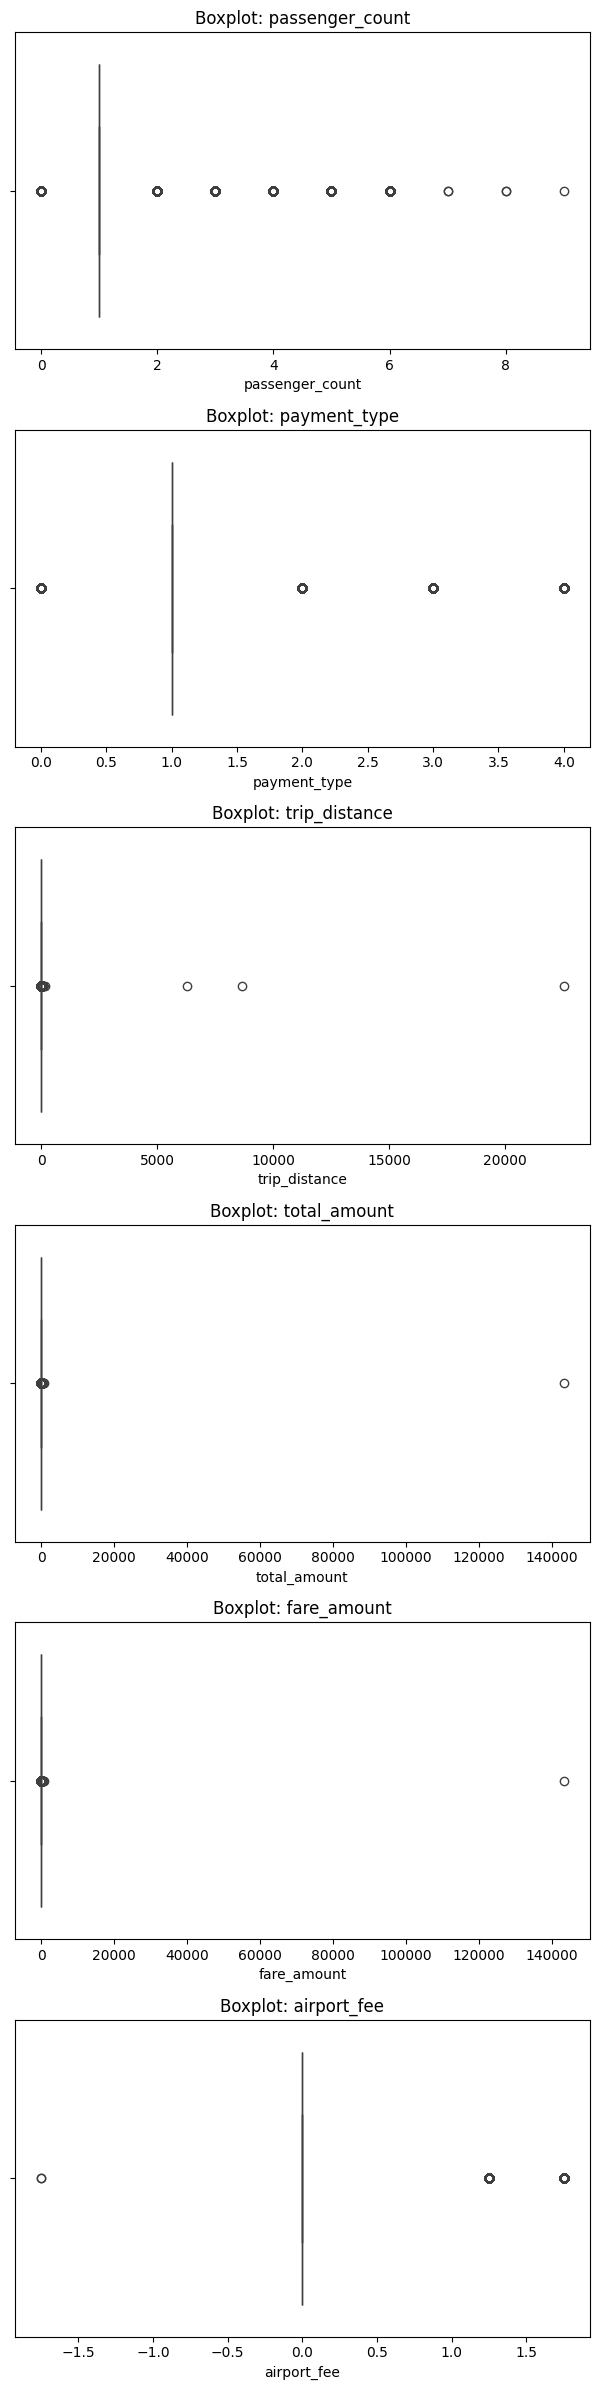

In [25]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns to be analyzed:", numeric_cols)

# IQR method: detect values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    return mask, lower, upper, q1, q3, iqr

iqr_summary = []
for col in numeric_cols:
    ser = df[col].dropna()
    if ser.empty:
        continue
    mask, lower, upper, q1, q3, iqr = iqr_outliers(ser)
    n_out = int(mask.sum())
    pct_out = n_out / len(ser) * 100
    iqr_summary.append((col, n_out, round(pct_out,4), lower, upper, q1, q3, iqr))
iqr_df = pd.DataFrame(iqr_summary, columns=['column','n_outliers','pct_out','lower','upper','q1','q3','iqr']).sort_values('n_outliers', ascending=False)

# Top suspected per-column plots
top_cols = list(iqr_df[iqr_df['n_outliers']>0]['column'].head(6))
if not top_cols:
    top_cols = numeric_cols[:6]

print("Plotting distributions for top columns:", top_cols)
n = len(top_cols)
plt.figure(figsize=(12, 4*n))
for i, c in enumerate(top_cols, 1):
    plt.subplot(n, 2, 2*i-1)
    sns.boxplot(x=df[c].dropna())
    plt.title(f'Boxplot: {c}')
plt.tight_layout()
plt.show()

**2.3.1**  
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [26]:
# remove passenger_count > 6

df_fixed = df.copy()
df_removed = pd.DataFrame(columns=df.columns)

# move rows to removed set
def remove_mask(mask, reason):
    global df_fixed, df_removed
    to_remove = df_fixed.loc[mask].copy()
    df_removed = pd.concat([df_removed, to_remove], ignore_index=True)
    df_fixed = df_fixed.loc[~mask].copy()
    print(f"Removed {len(to_remove)} rows for: {reason}")

# Drop passenger_count > 6
if 'passenger_count' in df_fixed.columns:
    df_fixed['passenger_count'] = pd.to_numeric(df_fixed['passenger_count'], errors='coerce')
    mask_pc = df_fixed['passenger_count'] > 6
    remove_mask(mask_pc, 'passenger_count > 6')

display(df_removed.head(5))

df = df_fixed

Removed 5 rows for: passenger_count > 6


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-11-30 00:13:36,2023-11-30 00:13:39,8.0,0.00,5.0,N,90,264,1,...,0.0,0.5,5.00,0.00,1.0,92.50,0.0,0.0,2023-11-30,0
1,2,2023-02-19 17:19:13,2023-02-19 17:57:24,9.0,16.79,5.0,N,186,1,1,...,0.0,0.0,18.00,14.75,1.0,123.75,0.0,0.0,2023-02-19,17
2,2,2023-04-09 09:22:54,2023-04-09 09:23:22,7.0,0.00,5.0,N,125,125,1,...,0.0,0.5,0.00,21.25,1.0,105.25,2.5,0.0,2023-04-09,9
3,2,2023-05-29 02:35:04,2023-05-29 02:35:16,7.0,0.00,5.0,N,256,256,1,...,0.0,0.0,0.02,0.00,1.0,76.02,0.0,0.0,2023-05-29,2
4,2,2023-09-18 13:07:26,2023-09-18 14:05:27,8.0,31.71,5.0,N,48,219,1,...,0.0,0.5,10.00,11.19,1.0,114.09,2.5,0.0,2023-09-18,13


In [27]:
# Continue with outlier handling

df_fixed = df.copy()
df_removed = pd.DataFrame(columns=df.columns)

def remove_mask(mask, reason):
    global df_fixed, df_removed
    to_remove = df_fixed.loc[mask].copy()
    df_removed = pd.concat([df_removed, to_remove], ignore_index=True)
    df_fixed = df_fixed.loc[~mask].copy()
    print(f"Removed {len(to_remove)} rows for: {reason}")

# 1) trip_distance nearly 0 and fare_amount > 300 [drop]
if 'trip_distance' in df_fixed.columns and 'fare_amount' in df_fixed.columns:
    df_fixed['trip_distance'] = pd.to_numeric(df_fixed['trip_distance'], errors='coerce')
    df_fixed['fare_amount'] = pd.to_numeric(df_fixed['fare_amount'], errors='coerce')
    mask_td_small_fare_large = (df_fixed['trip_distance'] <= 0.1) & (df_fixed['fare_amount'] > 300)
    remove_mask(mask_td_small_fare_large, 'trip_distance<=0.1 & fare_amount>300')

# 2) trip_distance == 0 and fare_amount == 0 but different pickup/dropoff zones [drop]
pu = 'PULocationID' if 'PULocationID' in df_fixed.columns else ('pickup_location_id' if 'pickup_location_id' in df_fixed.columns else None)
do = 'DOLocationID' if 'DOLocationID' in df_fixed.columns else ('dropoff_location_id' if 'dropoff_location_id' in df_fixed.columns else None)

if pu and do:
    mask_zero_zero_diff = (df_fixed['trip_distance'] == 0) & (df_fixed['fare_amount'] == 0) & (df_fixed[pu] != df_fixed[do])
    remove_mask(mask_zero_zero_diff, 'trip_distance==0 & fare_amount==0 & different_zones')

# 3) trip_distance > 250 miles [drop]
if 'trip_distance' in df_fixed.columns:
    mask_td_large = df_fixed['trip_distance'] > 250
    remove_mask(mask_td_large, 'trip_distance>250')

# 4) payment_type == 0 [ replace with 5 as Unknown ]
if 'payment_type' in df_fixed.columns:
    df_fixed['payment_type'] = pd.to_numeric(df_fixed['payment_type'], errors='coerce')
    mask_pay0 = df_fixed['payment_type'] == 0
    n_pay0 = int(mask_pay0.sum())
    if n_pay0 > 0:
        df_fixed.loc[mask_pay0, 'payment_type'] = 5
        print(f"Set payment_type==0 to 5 (Unknown) for {n_pay0} rows")
    else:
        print("No payment_type==0 rows found")

display(df_removed.head(5))

df = df_fixed

Removed 6 rows for: trip_distance<=0.1 & fare_amount>300
Removed 7 rows for: trip_distance==0 & fare_amount==0 & different_zones
Removed 3 rows for: trip_distance>250
Set payment_type==0 to 5 (Unknown) for 10215 rows


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-12-07 23:39:43,2023-12-07 23:39:59,1.0,0.0,5.0,N,265,265,2,...,0.0,0.0,0.0,0.0,1.0,320.0,0.0,0.0,2023-12-07,23
1,2,2023-12-24 14:01:07,2023-12-24 14:01:44,1.0,0.0,5.0,N,14,14,1,...,0.0,0.0,0.0,0.0,1.0,418.0,0.0,0.0,2023-12-24,14
2,2,2023-06-21 12:05:21,2023-06-21 12:05:42,1.0,0.0,5.0,N,265,265,2,...,0.0,0.0,0.0,0.0,1.0,501.0,0.0,0.0,2023-06-21,12
3,2,2023-06-29 20:56:07,2023-06-29 20:56:15,1.0,0.0,5.0,N,265,265,1,...,0.0,0.0,70.2,0.0,1.0,421.2,0.0,0.0,2023-06-29,20
4,1,2023-02-09 07:37:30,2023-02-09 07:39:13,1.0,0.0,5.0,N,246,246,4,...,0.0,0.0,0.0,0.0,1.0,911.0,0.0,0.0,2023-02-09,7


In [28]:
# Do any columns need standardising?

# VendorID, RatecodeID, payment_type can be treated as categorical variables rather than numeric.
# Convert them to string type for further analysis.
df['VendorID'] = df['VendorID'].astype(str)
df['RatecodeID'] = df['RatecodeID'].astype(str)
df['payment_type'] = df['payment_type'].astype(str)

# Numeric coercion for passenger_count
df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce').astype('Int32')

# Datetime coercion for datetime columns
df['pickup_date'] = pd.to_datetime(df['pickup_date'], errors='coerce')

# drop rows with invalid VendorID == 6
vendor_series = pd.to_numeric(df['VendorID'], errors="coerce")
invalid_mask = vendor_series == 6
df = df.loc[~invalid_mask].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303743 entries, 0 to 303837
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               303743 non-null  object        
 1   tpep_pickup_datetime   303743 non-null  datetime64[us]
 2   tpep_dropoff_datetime  303743 non-null  datetime64[us]
 3   passenger_count        303743 non-null  Int32         
 4   trip_distance          303743 non-null  float64       
 5   RatecodeID             303743 non-null  object        
 6   store_and_fwd_flag     303743 non-null  object        
 7   PULocationID           303743 non-null  int64         
 8   DOLocationID           303743 non-null  int64         
 9   payment_type           303743 non-null  object        
 10  fare_amount            303743 non-null  float64       
 11  extra                  303743 non-null  float64       
 12  mta_tax                303743 non-null  float64  

## **3** Exploratory Data Analysis

In [29]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pickup_date',
 'pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends

**3.1.1** 
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: category
* `tpep_pickup_datetime`: datetime
* `tpep_dropoff_datetime`: datetime
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: category
* `PULocationID`: category
* `DOLocationID`: category
* `payment_type`: category
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount` : Numerical
* `extra` : Numerical
* `mta_tax` : Numerical
* `tip_amount` : Numerical
* `tolls_amount` : Numerical
* `improvement_surcharge` : Numerical
* `total_amount` : Numerical
* `congestion_surcharge` : Numerical
* `airport_fee` : Numerical

##### Temporal Analysis

**3.1.2** 
Analyse the distribution of taxi pickups by hours, days of the week, and months.

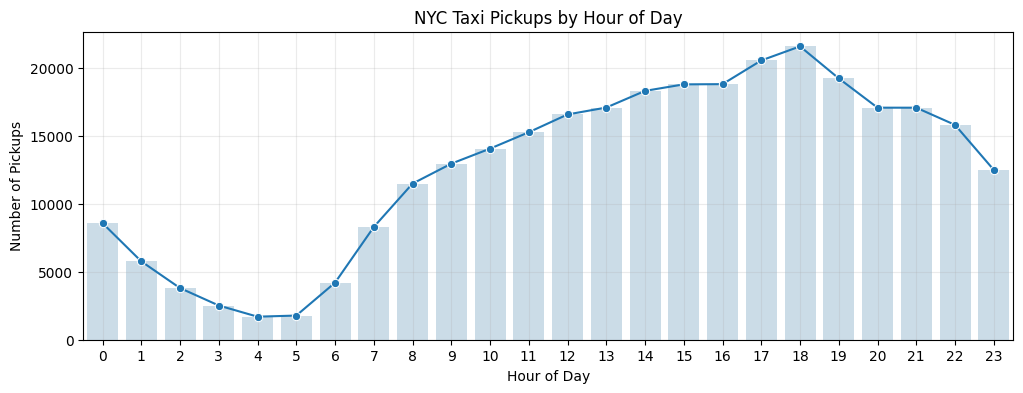

In [30]:
# Find and show the hourly trends in taxi pickups

# Hourly counts (0-23)
hourly_counts = df.groupby('pickup_hour').size().reindex(range(24), fill_value=0)

# Plot hourly counts (line + bar)
plt.figure(figsize=(12,4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o')
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, alpha=0.25, color='C0')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('NYC Taxi Pickups by Hour of Day')
plt.xticks(range(24))
plt.grid(alpha=0.25)
plt.show()

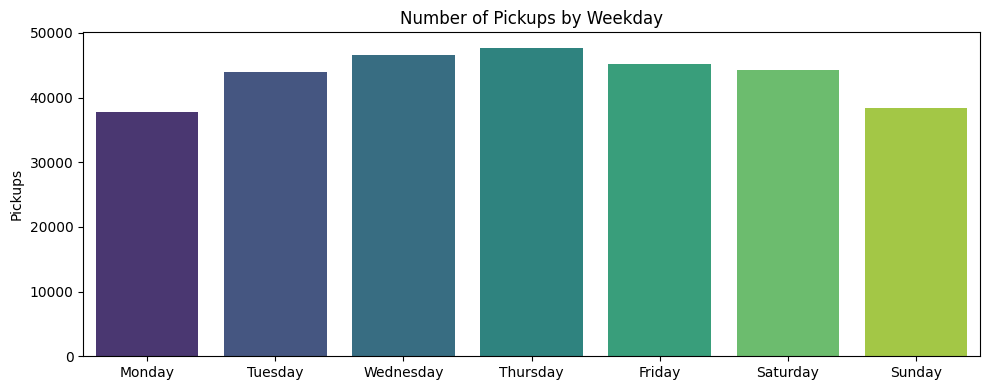

In [31]:
# Find and show the daily trends in taxi pickups (days of the week)

# Derive weekday (name) and keep canonical order
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.day_name()
df['pickup_weekday'] = pd.Categorical(df['pickup_weekday'], categories=weekday_order, ordered=True)

# Basic aggregations by weekday
agg = df.groupby('pickup_weekday').agg(
    pickups = ('tpep_pickup_datetime','size')
).reset_index()

# Bar plot pickups by weekday
plt.figure(figsize=(10,4))
sns.barplot(data=agg, x='pickup_weekday', y='pickups', palette='viridis')
plt.title('Number of Pickups by Weekday')
plt.xlabel('')
plt.ylabel('Pickups')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

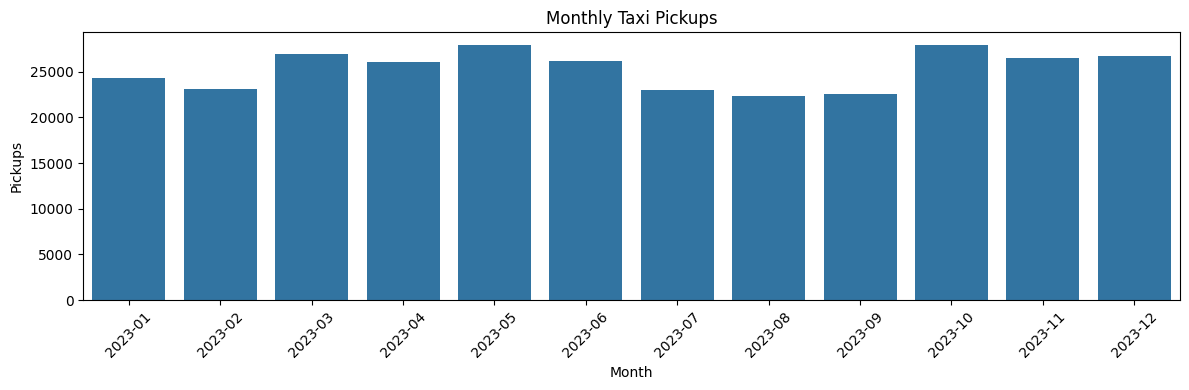

In [32]:
# Show the monthly trends in pickups

# Create a month index (period) and a month-start timestamp
df['pickup_month'] = df['tpep_pickup_datetime'].dt.to_period('M')
df['pickup_month_ts'] = df['pickup_month'].dt.to_timestamp()

# Aggregate monthly pickups
agg_month = df.groupby('pickup_month_ts').agg(
    pickups = ('tpep_pickup_datetime', 'size')
).sort_index()

# monthly pickup counts (line + bar)
plt.figure(figsize=(12,4))
sns.barplot(x=agg_month.index.to_series().dt.strftime('%Y-%m'), y=agg_month['pickups'], color='C0')
plt.xticks(rotation=45)
plt.title('Monthly Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Pickups')
plt.tight_layout()
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [33]:
# Analyse the above parameters

columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
print(f"shape={df.shape}")

# Summary of zero/negative counts
summary = []
for c in ['trip_distance','fare_amount','tip_amount','total_amount']:
    n_zero = int((df[c] == 0).sum())
    n_neg = int((df[c] < 0).sum())
    summary.append((c, n_zero, n_neg))

summary_df = pd.DataFrame(summary, columns=['column','Zero Count','Negative Count']).set_index('column')
display(summary_df)

shape=(303743, 24)


,Zero Count,Negative Count
column,,
trip_distance,5996,0
fare_amount,100,0
tip_amount,69750,0
total_amount,50,0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** 
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [34]:
# Create a df with non zero entries for the selected parameters.

selected_cols = ['fare_amount', 'total_amount', 'trip_distance']  # columns to check for zero

df_work = df.copy()

# compute zero masks
masks = {}
nrows_before = len(df_work)

for c in selected_cols:
    if c not in df_work.columns:
        masks[c] = pd.Series(False, index=df_work.index)
        continue
    else:
        masks[c] = df_work[c] == 0

# Special handling for trip_distance zeros when same zone
if 'trip_distance' in selected_cols and 'trip_distance' in df_work.columns:
    if 'PULocationID' in df_work.columns and 'DOLocationID' in df_work.columns:
        # don't treat trip_distance==0 as zero-to-drop when pickup and dropoff zones are equal
        same_zone = df_work['PULocationID'] == df_work['DOLocationID']
        masks['trip_distance'] = masks['trip_distance'] & (~same_zone)

# drop if any of the selected columns is zero
final_drop_mask = pd.concat([masks[c] for c in masks], axis=1).any(axis=1)

# Make the filtered copy
df_nonzero = df_work.loc[~final_drop_mask].copy()

print(f"Rows before: {nrows_before}")
print(f"Rows after filter: {len(df_nonzero)}\n")

# per-column drop counts
for c in selected_cols:
    if c in df_work.columns:
        n_c = int(masks[c].sum())
        print(f"Rows with {c} == 0: {n_c}")

df = df_nonzero

Rows before: 303743
Rows after filter: 300159

Rows with fare_amount == 0: 100
Rows with total_amount == 0: 50
Rows with trip_distance == 0: 3484


**3.1.4** 
Analyse the monthly revenue (`total_amount`) trend

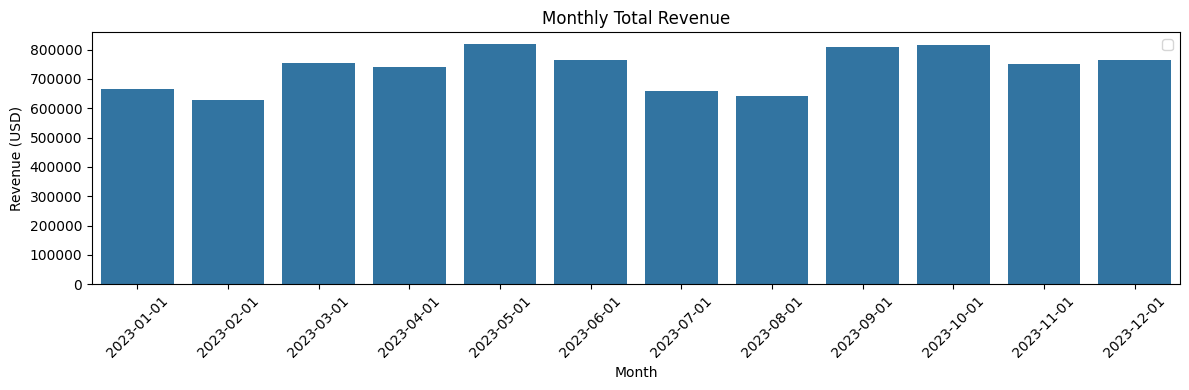

In [35]:
# Group data by month and analyse monthly revenue

# Create month index
df['month_start'] = df['tpep_pickup_datetime'].dt.to_period('M').dt.to_timestamp()

# Aggregate per month
monthly = df.groupby('month_start').agg(revenue_total = ('total_amount', 'sum')).sort_index()

# Bar plot
plt.figure(figsize=(12,4))
sns.barplot(x=monthly.index, y=monthly['revenue_total'])
plt.title('Monthly Total Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**3.1.5** 
Show the proportion of each quarter of the year in the revenue

In [36]:
# Calculate proportion of each quarter

# Keep only rows with valid datetime and revenue
df_q = df.dropna(subset=['tpep_pickup_datetime', 'total_amount']).copy()

# Create quarter and year columns
df_q['quarter'] = df_q['tpep_pickup_datetime'].dt.to_period('Q')  # e.g. 2023Q1

# quarterly totals and proportions
quarterly_total = df_q.groupby('quarter')['total_amount'].sum().sort_index()
overall_total = quarterly_total.sum()
quarterly_prop = (quarterly_total / overall_total * 100).round(2)

print("Overall quarterly revenue totals and proportion (% of total revenue):")
display(pd.DataFrame({
    'quarter': quarterly_total.index.astype(str),
    'revenue_total': quarterly_total.values,
    'pct_of_total': quarterly_prop.values
}).reset_index(drop=True))

Overall quarterly revenue totals and proportion (% of total revenue):


,quarter,revenue_total,pct_of_total
0,2023Q1,2048394.50,23.25
1,2023Q2,2324558.24,26.39
2,2023Q3,2106950.85,23.92
3,2023Q4,2328830.56,26.44


**3.1.6** 
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Pearson r = 0.0622
Spearman r = 0.9223


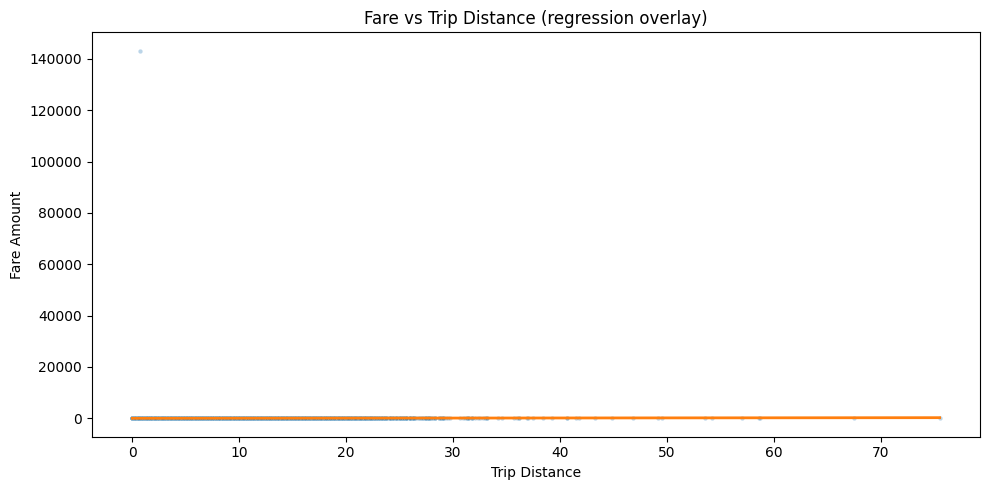

In [37]:
# Show how trip fare is affected by distance

# pick source dataframe
df_src = df.copy()

# ensure numeric
td = pd.to_numeric(df_src.get('trip_distance'), errors='coerce')
fa = pd.to_numeric(df_src.get('fare_amount'), errors='coerce')

# filter: drop NaNs and distance == 0
mask = td.notna() & fa.notna() & (td > 0)
x = td[mask]
y = fa[mask]

# correlations
x_s = pd.Series(x, dtype="float64")
y_s = pd.Series(y, dtype="float64")

# Pearson
pear_r = x_s.corr(y_s, method="pearson")

# Spearman
spear_r = x_s.rank().corr(y_s.rank(), method="pearson")

print(f"Pearson r = {pear_r:.4f}")
print(f"Spearman r = {spear_r:.4f}")

# scatter + regression line
sample_n = 50000
if len(x) > sample_n:
    sample_idx = np.random.choice(x.index, size=sample_n, replace=False)
    xs, ys = x.loc[sample_idx], y.loc[sample_idx]
else:
    xs, ys = x, y

plt.figure(figsize=(10,5))
sns.scatterplot(x=xs, y=ys, s=10, alpha=0.3)
sns.regplot(x=xs, y=ys, scatter=False, color='tab:orange', line_kws={'linewidth':2})
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare vs Trip Distance (regression overlay)')
plt.tight_layout()
plt.show()

**3.1.7** 
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Pearson r = 0.0182
Spearman r = 0.9363


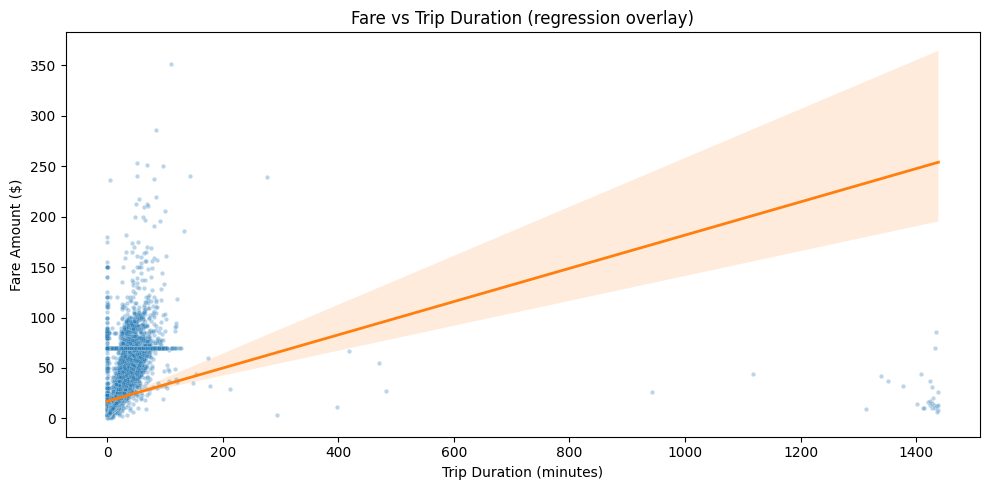

In [38]:
# Show relationship between fare and trip duration

# derive trip_duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0

df_work = df.copy()

# coerce fare_amount numeric
df_work['fare_amount'] = pd.to_numeric(df_work.get('fare_amount'), errors='coerce')

# filter: valid positive duration and non-negative fare
mask = df_work['trip_duration'].notna() & (df_work['trip_duration'] > 0) & df_work['fare_amount'].notna() & (df_work['fare_amount'] >= 0)
d = df_work.loc[mask, ['trip_duration','fare_amount']].copy()

# correlations
if len(d) > 1:
    x = d['trip_duration'].astype('float64')
    y = d['fare_amount'].astype('float64')

    # remove NaN pairs
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    if len(x) > 1:
        # Pearson correlation
        pear_r = x.corr(y, method='pearson')

        # Spearman correlation (rank + Pearson)
        spear_r = x.rank().corr(y.rank(), method='pearson')

        print(f"Pearson r = {pear_r:.4f}")
        print(f"Spearman r = {spear_r:.4f}")
    else:
        print("Not enough valid rows to compute correlation.")
else:
    print("Not enough rows to compute correlation.")

# scatter + regression line
sample_n = 50000
if len(d) > sample_n:
    d_plot = d.sample(sample_n, random_state=42)
else:
    d_plot = d

plt.figure(figsize=(10,5))
sns.scatterplot(data=d_plot, x='trip_duration', y='fare_amount', s=10, alpha=0.3)
sns.regplot(data=d_plot, x='trip_duration', y='fare_amount', scatter=False, color='tab:orange', line_kws={'linewidth':2})
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.title('Fare vs Trip Duration (regression overlay)')
plt.tight_layout()
plt.show()



Fare summary by passenger_count:


,passenger_count,trips,avg_fare,median_fare
0,1,228093,19.79,13.5
1,2,44045,22.26,14.2
2,3,10992,21.98,14.2
3,4,6052,23.26,14.9
4,5,3768,18.85,13.5
5,6,2567,18.98,13.5


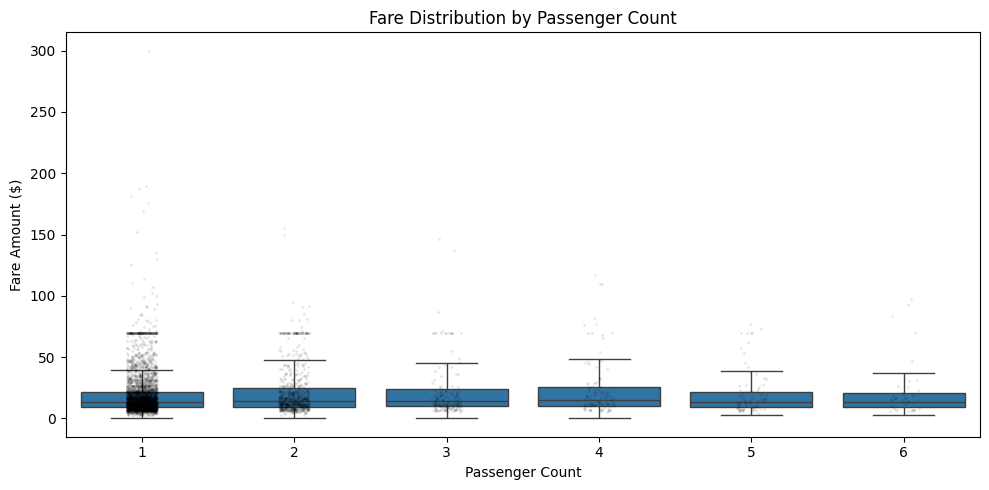

In [39]:
# Show relationship between fare and number of passengers

# pick source dataframe
df_src = df.copy()

# ensure numeric types
fa = pd.to_numeric(df_src.get('fare_amount'), errors='coerce')
pc = pd.to_numeric(df_src.get('passenger_count'), errors='coerce')

# filter: fare >= 0, passenger_count in [1, 7] (drop 0 or >7 as implausible)
mask = fa.notna() & pc.notna() & (fa >= 0) & (pc >= 1) & (pc <= 7)
d = pd.DataFrame({'fare_amount': fa[mask], 'passenger_count': pc[mask]})

# summary by passenger_count (mean/median fare and trips)
grouped = (d.groupby('passenger_count')
             .agg(trips=('fare_amount','size'),
                  avg_fare=('fare_amount','mean'),
                  median_fare=('fare_amount','median'))
             .reset_index()
             .sort_values('passenger_count'))
print("\nFare summary by passenger_count:")
display(grouped.round(2))

# boxplot: fare distribution per passenger count
plt.figure(figsize=(10,5))
sns.boxplot(data=d, x='passenger_count', y='fare_amount', showfliers=False)
sns.stripplot(data=d.sample(min(5000, len(d))), x='passenger_count', y='fare_amount',
              color='black', alpha=0.1, size=2)  # light jitter sample overlay
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.title('Fare Distribution by Passenger Count')
plt.tight_layout()
plt.show()

Pearson r = 0.5882
Spearman r = 0.4314


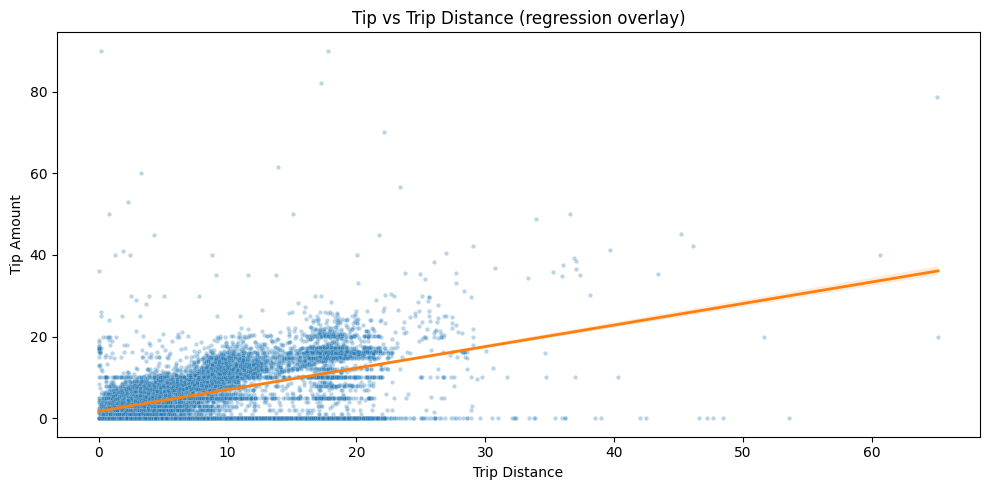

In [40]:
# Show relationship between tip and trip distance

# pick source dataframe
df_src = df.copy()

# ensure numeric
td = pd.to_numeric(df_src.get('trip_distance'), errors='coerce')
tip = pd.to_numeric(df_src.get('tip_amount'), errors='coerce')

# filter: drop NaNs and distance == 0; keep non-negative tips
mask = td.notna() & tip.notna() & (td > 0) & (tip >= 0)
x = td[mask]
y = tip[mask]

# correlations
if len(x) > 1:
    x_s = pd.Series(x, dtype="float64")
    y_s = pd.Series(y, dtype="float64")

    # drop NaN pairs
    mask = x_s.notna() & y_s.notna()
    x_s, y_s = x_s[mask], y_s[mask]

    if len(x_s) > 1:
        # Pearson correlation
        pear_r = x_s.corr(y_s, method="pearson")

        # Spearman correlation (rank + Pearson)
        spear_r = x_s.rank().corr(y_s.rank(), method="pearson")

        print(f"Pearson r = {pear_r:.4f}")
        print(f"Spearman r = {spear_r:.4f}")
    else:
        print("Not enough valid rows to compute correlation.")
else:
    print("Not enough rows to compute correlation.")

# scatter + regression line
idx = x.index
if len(idx) > sample_n:
    sample_idx = np.random.choice(idx, size=sample_n, replace=False)
    xs, ys = x.loc[sample_idx], y.loc[sample_idx]
else:
    xs, ys = x, y

plt.figure(figsize=(10,5))
sns.scatterplot(x=xs, y=ys, s=10, alpha=0.3)
sns.regplot(x=xs, y=ys, scatter=False, color='tab:orange', line_kws={'linewidth':2})
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.title('Tip vs Trip Distance (regression overlay)')
plt.tight_layout()
plt.show()

**3.1.8** 
Analyse the distribution of different payment types (`payment_type`)

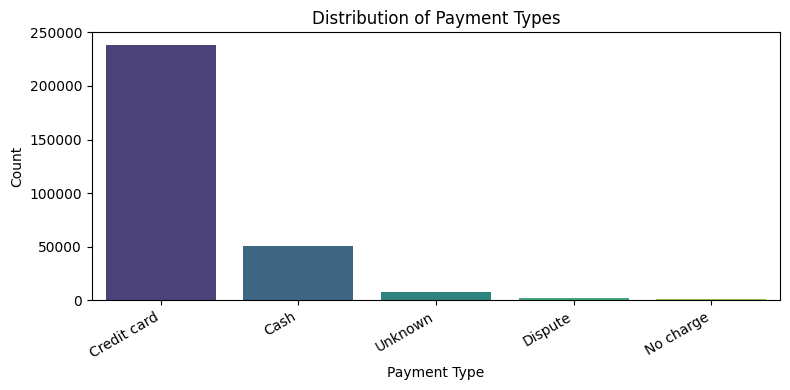

In [41]:
# Analyse the distribution of different payment types (payment_type).

# pick source dataframe
df_src = df.copy()

# ensure payment_type exists and numeric
if 'payment_type' not in df_src.columns:
    raise KeyError("Column 'payment_type' not found.")

pay_num = pd.to_numeric(df_src['payment_type'], errors='coerce')

# Map known codes; include 5=Unknown if present in your data cleaning
code_map = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute',
    5: 'Unknown'
}
labels = pay_num.map(code_map)

dist = (labels
        .fillna('Missing/Invalid')            # NaN or unparsable becomes Missing/Invalid
        .value_counts(dropna=False)
        .rename_axis('payment_type_label')
        .reset_index(name='count'))

dist['pct'] = dist['count'] / max(1, len(df_src)) * 100

# bar chart
plt.figure(figsize=(8,4))
sns.barplot(data=dist.sort_values('count', ascending=False),
            x='payment_type_label', y='count', palette='viridis')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
!pip install geopandas

**3.1.9** <br>
Load the shapefile and display it.

In [43]:
import geopandas as gpd

# Read the shapefile using geopandas

# Locate taxi_zones folder by walking up from current working directory
taxi_zones_path = None
for base in [Path.cwd(), Path.cwd().parent, *Path.cwd().parents]:
    candidate = base / "Datasets and Dictionary-NYC" / "Datasets and Dictionary" / "taxi_zones" / "taxi_zones.shp"
    if candidate.exists():
        taxi_zones_path = candidate
        break
if taxi_zones_path is None:
    raise FileNotFoundError("Could not find 'taxi_zones.shp' under any parent of CWD.")

zones = gpd.read_file(taxi_zones_path)
zones.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

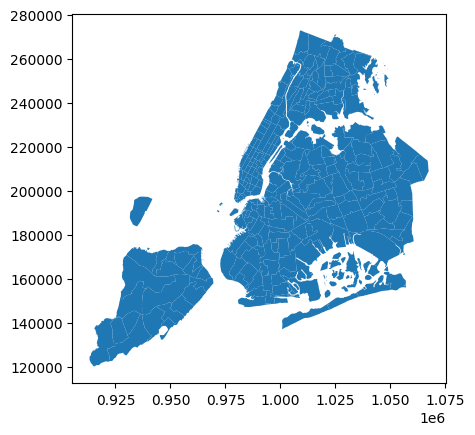

In [44]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [45]:
# Merge zones and trip records using locationID and PULocationID

zones_cp = zones.copy()

# Merge pickup locations with zones
merged_zone_trip = df.merge(
    zones_cp,
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

print(merged_zone_trip[['PULocationID', 'LocationID', 'zone', 'borough']].head(5))


   PULocationID  LocationID                   zone    borough
0           138       138.0      LaGuardia Airport     Queens
1           161       161.0         Midtown Center  Manhattan
2           237       237.0  Upper East Side South  Manhattan
3           143       143.0    Lincoln Square West  Manhattan
4            66        66.0     DUMBO/Vinegar Hill   Brooklyn


**3.1.11** <br>
Group data by location IDs to find the total number of trips per location ID

In [46]:
# Group data by location and calculate the number of trips

# Count trips per pickup LocationID
pickup_counts = (
    merged_zone_trip
    .groupby("PULocationID", dropna=False)
    .size()
    .rename("num_trips")
    .reset_index()
)

print(pickup_counts.head())


   PULocationID  num_trips
0             1         42
1             3          9
2             4        338
3             5          2
4             6          3


**3.1.12** <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [47]:
# Merge trip counts back to the zones GeoDataFrame

# Count trips per pickup LocationID
pickup_counts = (
    merged_zone_trip
    .groupby("PULocationID", dropna=False)
    .size()
    .rename("trip_count_pickup")
    .reset_index()
    .rename(columns={"PULocationID": "LocationID"})
)

zones_with_trips = zones.merge(
    pickup_counts,
    on="LocationID",
    how="left"
)

zones_with_trips = gpd.GeoDataFrame(zones_with_trips, geometry="geometry", crs=zones.crs)

show_cols = ["trip_count_pickup", "borough", "LocationID", "zone"]
print(zones_with_trips[show_cols].sort_values("trip_count_pickup", ascending=False).head(10))

     trip_count_pickup    borough  LocationID                          zone
131            15434.0     Queens         132                   JFK Airport
236            14063.0  Manhattan         237         Upper East Side South
160            13906.0  Manhattan         161                Midtown Center
235            12663.0  Manhattan         236         Upper East Side North
161            10759.0  Manhattan         162                  Midtown East
137            10209.0     Queens         138             LaGuardia Airport
185            10140.0  Manhattan         186  Penn Station/Madison Sq West
229             9910.0  Manhattan         230     Times Sq/Theatre District
141             9845.0  Manhattan         142           Lincoln Square East
169             8824.0  Manhattan         170                   Murray Hill


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <br>
Plot a color-coded map showing zone-wise trips

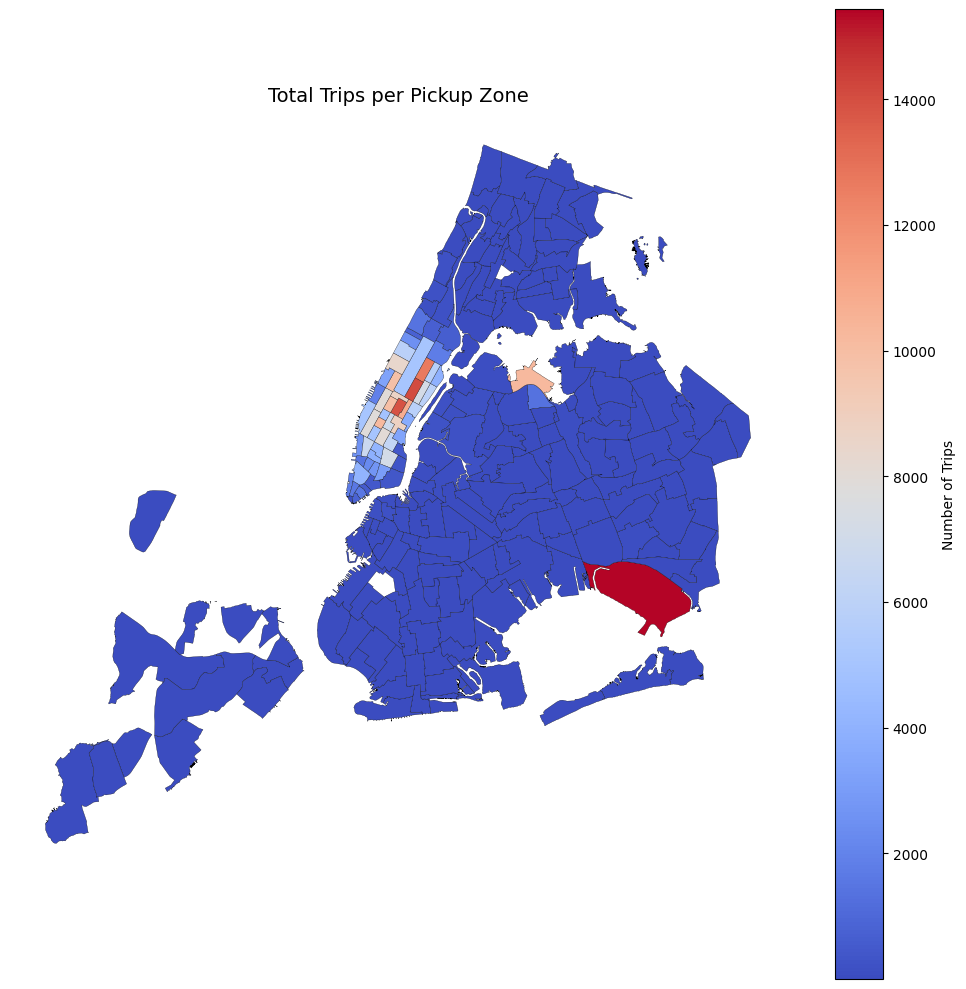

In [48]:
# Define figure and axis
# Plot the map and display it

zdf = zones_with_trips.copy()

fig, ax = plt.subplots(figsize=(10, 10))
zdf.plot(
    column="trip_count_pickup",
    ax=ax,
    legend=True,
    legend_kwds={'label': "Number of Trips",'orientation': "vertical"},
    cmap="coolwarm",
    edgecolor="black",
    linewidth=0.2
)
ax.set_title("Total Trips per Pickup Zone", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [49]:
# can you try displaying the zones DF sorted by the number of trips?

sorted_zones = zdf.sort_values("trip_count_pickup", ascending=False)
sorted_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,trip_count_pickup
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",15434.0
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",14063.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",13906.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",12663.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",10759.0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones



Busiest Hours: Commute peaks across morning and evening, mid-day steady,  and late-night low.
Busiest Days: Weekends and Fridays typically higher trip volumes than midweek.
Busiest Months: Clear seasonality with summer months peaking, holiday-related dips present.
Revenue Trends
Monthly Revenue: Upward trend into summer, slight softening post-peak, stable baseline outside peak season.
Quarterly Revenue: Q3 highest, followed by Q2, Q4 and Q1 lower reflecting seasonality.
Fare Relationships
Distance & Fare: Strong positive relationship, fare increases near-linearly with trip distance, with higher variance at long distances.
Duration & Fare: Positive association, longer trips cost more, tempered by traffic and time-based components.
Passenger Count & Fare: Weak and limited impact, slight increases for higher counts, but not a primary driver.
Tip Relationships
Distance & Tip: Mild positive correlation, longer trips see higher average tips, though variability is large.
Geography
Busiest Pickup Zones: High activity concentrated in central Manhattan (Midtown, Lower Manhattan) and airport zones (JFK, LGA).
Choropleth Insight: Trip counts cluster around transit hubs, commercial cores, and major connectors, peripheral zones show lower intensity.


#### **3.2** Detailed EDA: Insights and Strategies


Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** 
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [50]:
# Find routes which have the slowest speeds at different times of the day

trips = merged_zone_trip.copy()
required_cols = ['PULocationID', 'DOLocationID', 'trip_distance', 'tpep_pickup_datetime']
trips['trip_duration_hrs'] = (trips['tpep_dropoff_datetime'] - trips['tpep_pickup_datetime']).dt.total_seconds() / 3600

# Create hour bucket
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour

# Clean invalid rows
trips = trips.dropna(subset=['trip_distance', 'trip_duration_hrs', 'PULocationID', 'DOLocationID', 'pickup_hour'])
trips = trips[(trips['trip_distance'] > 0) & (trips['trip_duration_hrs'] > 0)]

grouped = trips.groupby(['PULocationID', 'DOLocationID', 'pickup_hour'])
calculate_speed = grouped.agg({
    'trip_distance': 'median',
    'trip_duration_hrs': 'mean'
}).reset_index()
calculate_speed['speed_mph'] = calculate_speed['trip_distance'] / calculate_speed['trip_duration_hrs']
slowest_routes = calculate_speed.sort_values(by='speed_mph').head()
print(slowest_routes[['PULocationID', 'DOLocationID', 'pickup_hour', 'speed_mph']])

       PULocationID  DOLocationID  pickup_hour  speed_mph
48124           226           145           18   0.026569
62426           260           129           17   0.040746
17788           113           113           13   0.043484
46450           209           232           13   0.043579
18363           113           235           22   0.048105


How does identifying high-traffic, high-demand routes help us?

<br>

Summary

Capacity Planning: Align driver supply with peak routes and hours to reduce wait times and increase fulfilment rates.
Dispatch Optimization: Prioritize matching and repositioning toward high-demand corridors to cut empty miles and idle time.
Dynamic Pricing: Set smarter surge thresholds where demand is persistent, improving revenue while managing service reliability.
Fleet Efficiency: Identify bottlenecks, reroute or time-shift drivers to avoid congestion, lowering trip duration variability and fuel costs.
Service Design: Add preferred pickup/drop-off points and micro‑hubs in hot zones to streamline boarding and reduce cancellations.
Customer Experience: Shorter ETAs and more consistent fares on busy routes improve satisfaction and repeat usage.
Infrastructure Insight: Surface chronic slow corridors for stakeholder dialogue (city, airports) on curb space, signals, or lane policies.
Partner Strategy: Target marketing and partnerships (events, venues, business districts) along top routes to lift utilization.
Forecasting & Staffing: Improve demand forecasts, schedule driver shifts and incentives around predictable route peaks.
Risk Management: Spot routes with high delay or incident rates, adjust guidance, training, or safety measures accordingly.

**3.2.2** <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

Busiest hour: 18:00 with 21307 trips


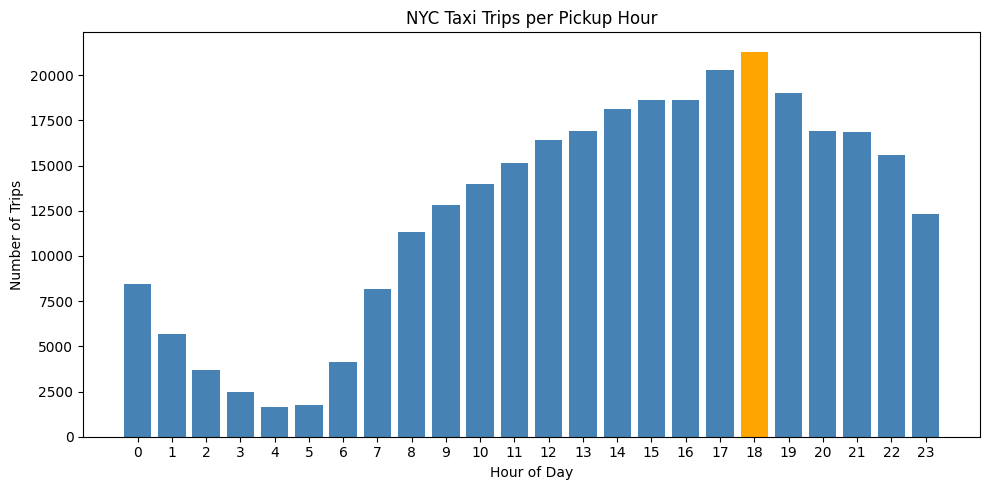

In [51]:
# Visualise the number of trips per hour and find the busiest hour

trips = merged_zone_trip.copy()

# Create hour of day
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour

# Compute trips per hour
trips_per_hour = trips.groupby('pickup_hour').size().reset_index(name='n_trips').sort_values('pickup_hour')

# Find busiest hour
busiest_row = trips_per_hour.loc[trips_per_hour['n_trips'].idxmax()]
busiest_hour = int(busiest_row['pickup_hour'])
busiest_count = int(busiest_row['n_trips'])

print(f"Busiest hour: {busiest_hour:02d}:00 with {busiest_count} trips")

# Visualize trips per hour
plt.figure(figsize=(10, 5))
plt.bar(trips_per_hour['pickup_hour'], trips_per_hour['n_trips'], color='steelblue')
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('NYC Taxi Trips per Pickup Hour')

# Highlight busiest hour
plt.bar(busiest_hour, busiest_count, color='orange')
plt.tight_layout()
plt.show()

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3**  <br>
Find the actual number of trips in the five busiest hours

In [52]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers

# Compute five busiest hours and scale counts by sampling fraction

SAMPLING_FRACTION = 0.008  # <-- update this to your actual fraction

trips = merged_zone_trip.copy()

# Compute trips per hour
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour
trips_per_hour = trips.groupby('pickup_hour').size().reset_index(name='sampled_trips').sort_values('pickup_hour')

# Scale up to actual counts
trips_per_hour['actual_trips'] = (trips_per_hour['sampled_trips'] / SAMPLING_FRACTION).round().astype(int)

# Find five busiest hours by actual trips
top5 = trips_per_hour.sort_values('actual_trips', ascending=False).head(5).reset_index(drop=True)

print("Five busiest hours (scaled by sampling fraction):")
print(top5[['pickup_hour', 'sampled_trips', 'actual_trips']].to_string(index=False))



Five busiest hours (scaled by sampling fraction):
 pickup_hour  sampled_trips  actual_trips
          18          21307       2663375
          17          20307       2538375
          19          19019       2377375
          16          18622       2327750
          15          18610       2326250


**3.2.4**  <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

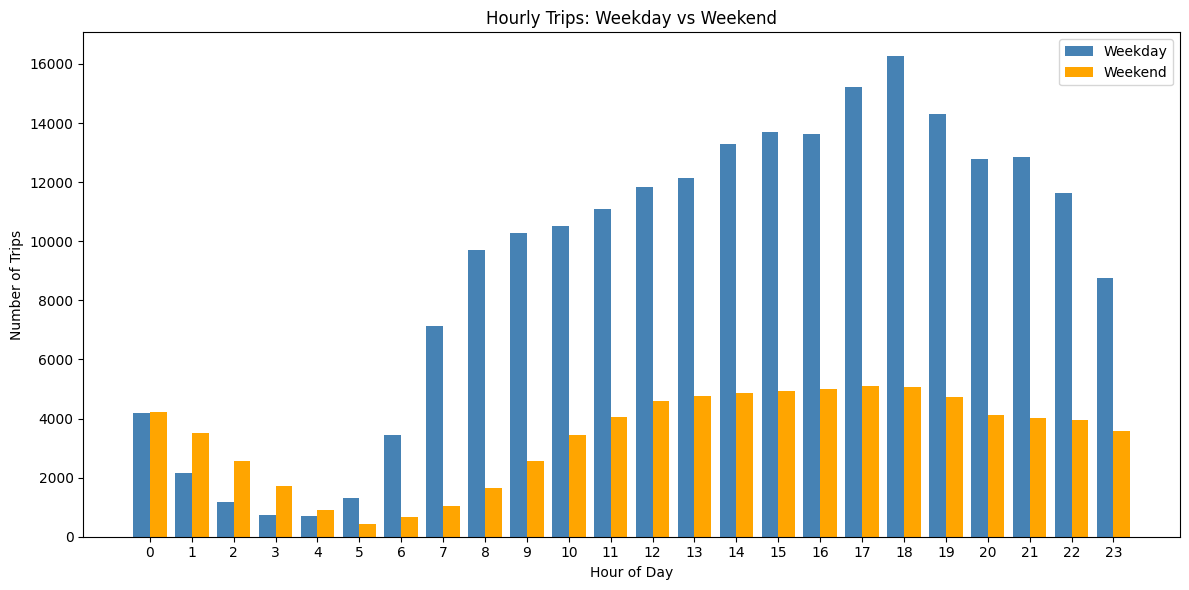

In [53]:
# Compare traffic trends for the week days and weekends

trips = merged_zone_trip.copy()

# Prepare hour and weekday/weekend flag
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour
trips['weekday'] = trips['tpep_pickup_datetime'].dt.weekday
trips['is_weekend'] = np.where(trips['weekday'] >= 5, 'Weekend', 'Weekday')

# Aggregate trips per hour for weekday/weekend
hourly_wd_we = (
trips.groupby(['is_weekend', 'pickup_hour'])
.size()
.reset_index(name='n_trips')
.sort_values(['is_weekend', 'pickup_hour'])
)

# Pivot for plotting side-by-side bars
pivot = hourly_wd_we.pivot(index='pickup_hour', columns='is_weekend', values='n_trips').fillna(0)
pivot = pivot.reindex(range(24), fill_value(0)) if not set(pivot.index) == set(range(24)) else pivot

# Plot: Weekday vs Weekend hourly trips
plt.figure(figsize=(12, 6))
bar_width = 0.4
hours = np.arange(24)

weekday_vals = pivot['Weekday'] if 'Weekday' in pivot.columns else np.zeros(24)
weekend_vals = pivot['Weekend'] if 'Weekend' in pivot.columns else np.zeros(24)

plt.bar(hours - bar_width/2, weekday_vals, width=bar_width, label='Weekday', color='steelblue')
plt.bar(hours + bar_width/2, weekend_vals, width=bar_width, label='Weekend', color='orange')
plt.xticks(hours)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Hourly Trips: Weekday vs Weekend')
plt.legend()
plt.tight_layout()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

 <br>

Summary:

Demand Shape: Weekdays show pronounced commute peaks (morning/evening), weekends shift later with flatter midday peaks and softer late night tails. This indicates different rider intents (work vs leisure) and timing.
Staffing & Supply: Align driver availability to peak hours per day. Schedule more drivers for weekday commute windows, shift coverage later on weekends to cut ETAs, cancellations, and idle time.
Dynamic Pricing: Calibrate surge rules by hour/day to smooth demand-supply gaps. Lower thresholds during predictable peaks, relax during quiet hours to maintain affordability and utilization.
Dispatch & Repositioning: Proactively move drivers toward emerging hotspots before peaks (pre-commute staging), reduce empty miles, and improve match rates during busy hours.
Marketing & Incentives: Target quiet hours with promotions or driver incentives to lift utilization, and reward peak-hour reliability to retain drivers where service is most needed.
Operational Efficiency: Use quiet hours for maintenance/training and busy hours for maximum throughput, plan break rotations and fueling to avoid peak-time bottlenecks.
Forecasting & SLAs: Hour-by-hour patterns improve short-term forecasts and service level targets (ETAs, acceptance rates) tailored to each day’s rhythm.
Customer Experience: Communicate expected busy periods, suggest off-peak alternatives, and optimize pickup points in peak corridors to reduce wait and variability.

**3.2.5**  <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [54]:
# Find top 10 pickup and dropoff zones

trips = merged_zone_trip.copy()
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour

# Top 10 pickup zones by total pickups
top10_pickup_zones = (
    trips.groupby('PULocationID')
          .size()
          .reset_index(name='total_pickups')
          .sort_values('total_pickups', ascending=False)
          .head(10)
)

print("Top 10 Pickup Zones:")
print(top10_pickup_zones)

# Top 10 dropoff zones by total dropoffs
top10_dropoff_zones = (
    trips.groupby('DOLocationID')
          .size()
          .reset_index(name='total_dropoffs')
          .sort_values('total_dropoffs', ascending=False)
          .head(10)
)

print("\nTop 10 Dropoff Zones:")
print(top10_dropoff_zones)


Top 10 Pickup Zones:
     PULocationID  total_pickups
117           132          15434
215           237          14063
145           161          13906
214           236          12663
146           162          10759
123           138          10209
166           186          10140
208           230           9910
127           142           9845
154           170           8824

Top 10 Dropoff Zones:
     DOLocationID  total_dropoffs
226           236           13387
227           237           12583
153           161           11737
220           230            9095
162           170            8904
154           162            8576
134           142            8501
229           239            8319
133           141            7801
66             68            7666


**3.2.6**  <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [55]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Ratio of pickups to dropoffs per zone; show top/bottom 10

trips = merged_zone_trip.copy()
zones_gdf = zones_with_trips.copy()

# Compute pickups and dropoffs per zone
pu_counts = trips.groupby('PULocationID').size().reset_index(name='pickups').rename(columns={'PULocationID': 'LocationID'})
do_counts = trips.groupby('DOLocationID').size().reset_index(name='dropoffs').rename(columns={'DOLocationID': 'LocationID'})
zone_counts = pu_counts.merge(do_counts, on='LocationID', how='outer').fillna(0)

zone_lut = zones_gdf[['LocationID', 'zone']].drop_duplicates().copy()

zone_counts = zone_counts.merge(zone_lut, on='LocationID', how='left')

# Compute ratios; then restrict rankings to zones with BOTH pickups>0 and dropoffs>0
zone_counts['pickup_drop_ratio'] = np.where(zone_counts['dropoffs'] > 0, zone_counts['pickups'] / zone_counts['dropoffs'], np.nan)
zone_counts['drop_pickup_ratio'] = np.where(zone_counts['pickups'] > 0, zone_counts['dropoffs'] / zone_counts['pickups'], np.nan)

valid_zones = zone_counts[(zone_counts['pickups'] > 0) & (zone_counts['dropoffs'] > 0)].copy()
valid_zones = valid_zones[valid_zones['pickup_drop_ratio'].notna() & valid_zones['drop_pickup_ratio'].notna()]

# Top/bottom 10 by pickup/drop ratio (exclude zeros-only zones)
top10_pickup_drop = valid_zones.sort_values('pickup_drop_ratio', ascending=False).head(10)
bottom10_pickup_drop = valid_zones.sort_values('pickup_drop_ratio', ascending=True).head(10)

# Display results (include zone names)
print("Top 10 zones by pickups/dropoffs ratio:")
print(top10_pickup_drop[['zone', 'pickup_drop_ratio']].to_string(index=False))

print("\nBottom 10 zones by pickups/dropoffs ratio:")
print(bottom10_pickup_drop[['zone', 'pickup_drop_ratio']].to_string(index=False))


Top 10 zones by pickups/dropoffs ratio:
                        zone  pickup_drop_ratio
               East Elmhurst           8.138554
                 JFK Airport           4.337830
           LaGuardia Airport           2.643449
Penn Station/Madison Sq West           1.513885
                Central Park           1.364693
                West Village           1.360981
     Greenwich Village South           1.338164
                Midtown East           1.254548
            Garment District           1.185339
              Midtown Center           1.184800

Bottom 10 zones by pickups/dropoffs ratio:
                               zone  pickup_drop_ratio
                         Whitestone           0.033898
                Ocean Parkway South           0.041667
                          Glen Oaks           0.043478
                    Windsor Terrace           0.043796
                     Newark Airport           0.046460
                            Bayside           0.049180
Riv

**3.2.7** <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [56]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

trips = merged_zone_trip.copy()
zones_gdf = zones_with_trips.copy()

trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour

# Night hours mask: 23:00–23:59 or 00:00–05:59
night_mask = (trips['pickup_hour'] == 23) | (trips['pickup_hour'] <= 5)
night_trips = trips[night_mask].copy()

# Top 10 night pickup zones
pu_night = night_trips.groupby('PULocationID').size().reset_index(name='night_pickups')
top10_pu = pu_night.sort_values('night_pickups', ascending=False).head(10).reset_index(drop=True)

# Top 10 night dropoff zones
do_night = night_trips.groupby('DOLocationID').size().reset_index(name='night_dropoffs')
top10_do = do_night.sort_values('night_dropoffs', ascending=False).head(10).reset_index(drop=True)

zone_lut = zones_gdf[['LocationID', 'zone']].drop_duplicates().copy()

# Attach zone names
pu_with_names = top10_pu.rename(columns={'PULocationID': 'LocationID'}).merge(zone_lut, on='LocationID', how='left')[['LocationID', 'zone', 'night_pickups']]
do_with_names = top10_do.rename(columns={'DOLocationID': 'LocationID'}).merge(zone_lut, on='LocationID', how='left')[['LocationID', 'zone', 'night_dropoffs']]

# Display results
print("Top 10 pickup zones during night hours :")
print(pu_with_names.to_string(index=False))
print("\nTop 10 dropoff zones during night hours:")
print(do_with_names.to_string(index=False))

Top 10 pickup zones during night hours :
 LocationID                         zone  night_pickups
         79                 East Village           2588
        132                  JFK Airport           2330
        249                 West Village           2084
         48                 Clinton East           1689
        148              Lower East Side           1609
        114      Greenwich Village South           1389
        230    Times Sq/Theatre District           1384
        186 Penn Station/Madison Sq West           1146
        164                Midtown South           1016
        138            LaGuardia Airport            995

Top 10 dropoff zones during night hours:
 LocationID                  zone  night_dropoffs
         79          East Village            1383
         48          Clinton East            1176
        170           Murray Hill            1022
         68          East Chelsea             973
        107              Gramercy             957
 

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8**  <br>
Find the revenue share for nighttime and daytime hours.

In [57]:
# Filter for night hours (11 PM to 5 AM)

# Revenue share: Night (23:00–05:59) vs Day (06:00–22:59)

trips = merged_zone_trip.copy()

# Prepare datetime and hour
trips['pickup_hour'] = trips['tpep_pickup_datetime'].dt.hour

# Define night/day masks: Night = 23:00–05:59, Day = 06:00–22:59
night_mask = (trips['pickup_hour'] == 23) | (trips['pickup_hour'] <= 5)
day_mask = (trips['pickup_hour'] >= 6) & (trips['pickup_hour'] <= 22)

# Compute revenue sums
night_revenue = trips.loc[night_mask, 'total_amount'].sum()
day_revenue = trips.loc[day_mask, 'total_amount'].sum()
total_revenue = night_revenue + day_revenue

# Avoid division by zero
if total_revenue == 0:
    raise ValueError("Total revenue is zero; cannot compute shares.")
night_share_pct = (night_revenue / total_revenue) * 100.0
day_share_pct = (day_revenue / total_revenue) * 100.0

# Display results
print("Revenue share night and day time hours:")
print(f"Night: revenue = ${night_revenue:,.2f}, share = {night_share_pct:.2f}%")
print(f"Day: revenue = ${day_revenue:,.2f}, share = {day_share_pct:.2f}%")

Revenue share night and day time hours:
Night: revenue = $1,067,057.93, share = 12.11%
Day: revenue = $7,742,737.72, share = 87.89%


##### Pricing Strategy

**3.2.9**  <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [58]:
# Analyse the fare per mile per passenger for different passenger counts
trips = merged_zone_trip.copy()

trips = trips[(trips['trip_distance'] > 0) & (trips['passenger_count'] > 0) & (trips['total_amount'] >= 0)]

# Compute fare per mile and per passenger
trips['fare_per_mile'] = trips['total_amount'] / trips['trip_distance']
trips['fare_per_mile_per_passenger'] = trips['fare_per_mile'] / trips['passenger_count']

result = (trips.groupby('passenger_count', as_index=False).agg(avg_fare_per_mile_per_passenger=('fare_per_mile_per_passenger', 'mean')))

print(result.sort_values('passenger_count').to_string(index=False, float_format=lambda x: f"{x:.2f}"))


 passenger_count  avg_fare_per_mile_per_passenger
               1                            17.38
               2                             9.17
               3                             6.07
               4                             6.92
               5                             2.65
               6                             2.09


**3.2.10** <br>
Find the average fare per mile by hours of the day and by days of the week

In [59]:
# Compare the average fare per mile for different days and for different times of the day

# Average fare per mile by hour of day and day of week

df_use = merged_zone_trip.copy()

#  filter valid rows
df_use = df_use.loc[df_use['tpep_pickup_datetime'].notna() & (df_use['trip_distance'] > 0) & (df_use['total_amount'] >= 0)]

# Compute fare per mile and time features
df_use['fare_per_mile'] = df_use['total_amount'] / df_use['trip_distance']
df_use['hour_of_day'] = df_use['tpep_pickup_datetime'].dt.hour
df_use['day_of_week'] = df_use['tpep_pickup_datetime'].dt.day_name()

# Averages
hourly_avg = (
    df_use.groupby('hour_of_day', as_index=False)['fare_per_mile']
    .mean()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = (
    df_use.groupby('day_of_week', as_index=False)['fare_per_mile']
    .mean()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)
dow_avg['day_of_week'] = pd.Categorical(dow_avg['day_of_week'], categories=order_days, ordered=True)


display(hourly_avg.style.hide(axis="index"))

display(dow_avg.sort_values('day_of_week').style.hide(axis="index"))


hour_of_day,avg_fare_per_mile
0,16.713528
1,19.972707
2,14.119125
3,16.016258
4,26.020969
5,16.371254
6,17.995639
7,12.873920
8,14.535945
9,15.672374


day_of_week,avg_fare_per_mile
Monday,16.004423
Tuesday,21.911992
Wednesday,17.334284
Thursday,18.673340
Friday,15.487594
Saturday,16.564001
Sunday,17.065971


**3.2.11** <br>
Analyse the average fare per mile for the different vendors for different hours of the day

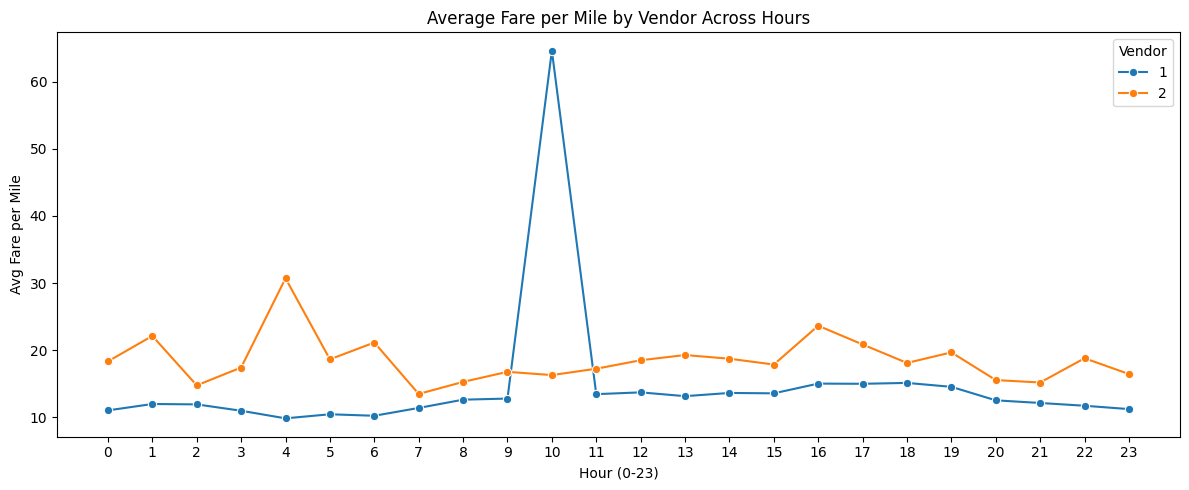

vendor,1,2
pickup_hour,,
0,11.043059,18.337543
1,11.992645,22.128991
2,11.935035,14.768617
3,10.987098,17.421857
4,9.857352,30.711067
5,10.463041,18.643274
6,10.239369,21.146874
7,11.405610,13.490923
8,12.636417,15.282802


In [60]:
# Compare fare per mile for different vendors

# Average fare per mile by vendor across hours of the day

df_use = merged_zone_trip.copy()

df_use = df_use.loc[df_use['tpep_pickup_datetime'].notna() & (df_use['trip_distance'] > 0) & (df_use['total_amount'] >= 0)]

# Compute fare per mile and time features
df_use['fare_per_mile'] = df_use['total_amount'] / df_use['trip_distance']
df_use['pickup_hour'] = df_use['tpep_pickup_datetime'].dt.hour
df_use['vendor'] = df_use["VendorID"].astype(str)

# Aggregations
vendor_hour_avg = (df_use.groupby(['vendor', 'pickup_hour'], as_index=False)['fare_per_mile'].mean().rename(columns={'fare_per_mile': 'avg_fare_per_mile'}))

# Plot Average fare per mile by vendor across hours
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=vendor_hour_avg.sort_values(['vendor', 'pickup_hour']),
    x='pickup_hour',
    y='avg_fare_per_mile',
    hue='vendor',
    marker='o',
    palette='tab10'
)
plt.title('Average Fare per Mile by Vendor Across Hours')
plt.xlabel('Hour (0-23)')
plt.ylabel('Avg Fare per Mile')
plt.xticks(range(0, 24))
plt.legend(title='Vendor')
plt.tight_layout()
plt.show()

pivot_vendor_hour = vendor_hour_avg.pivot(index='pickup_hour', columns='vendor', values='avg_fare_per_mile').reindex(range(24))
display(pivot_vendor_hour)

**3.2.12**  <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


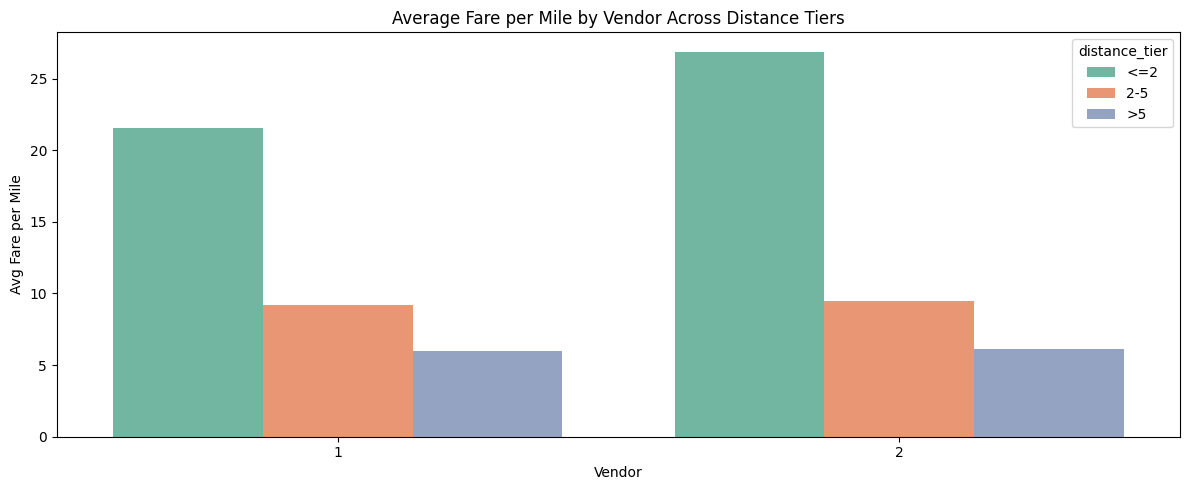

,vendor,distance_tier,avg_fare_per_mile
0,1,<=2,21.571119
1,1,2-5,9.193452
2,1,>5,5.971863
3,2,<=2,26.878554
4,2,2-5,9.437341
5,2,>5,6.141808


In [61]:
# Defining distance tiers

df_use = merged_zone_trip.copy()

df_use = df_use.loc[(df_use['trip_distance'] > 0) & (df_use['total_amount'] >= 0)]

# Prepare features
df_use['fare_per_mile'] = df_use['total_amount'] / df_use['trip_distance']
df_use['vendor'] = df_use['VendorID'].astype(str)

# Define distance tiers
bins = [0, 2, 5, np.inf]
labels = ['<=2', '2-5', '>5']
df_use['distance_tier'] = pd.cut(
    df_use['trip_distance'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)
df_use['distance_tier'] = pd.Categorical(df_use['distance_tier'], categories=labels, ordered=True)

# Aggregations: average fare per mile by vendor and tier
vendor_tier_avg = (
    df_use.groupby(['vendor', 'distance_tier'], as_index=False)
    .agg(avg_fare_per_mile=('fare_per_mile', 'mean'))
)

# Plot: tiered comparison by vendor
plt.figure(figsize=(12, 5))
sns.barplot(
    data=vendor_tier_avg,
    x='vendor',
    y='avg_fare_per_mile',
    hue='distance_tier',
    palette='Set2'
)
plt.title('Average Fare per Mile by Vendor Across Distance Tiers')
plt.xlabel('Vendor')
plt.ylabel('Avg Fare per Mile')
plt.tight_layout()
plt.show()

display(vendor_tier_avg.sort_values(['vendor', 'distance_tier']))
pivot_vendor_tier = vendor_tier_avg.pivot(index='vendor', columns='distance_tier', values='avg_fare_per_mile').sort_index()


##### Customer Experience and Other Factors

**3.2.13**  <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

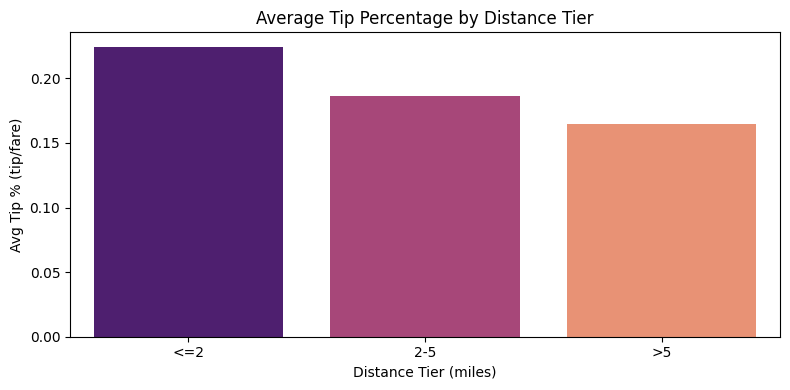

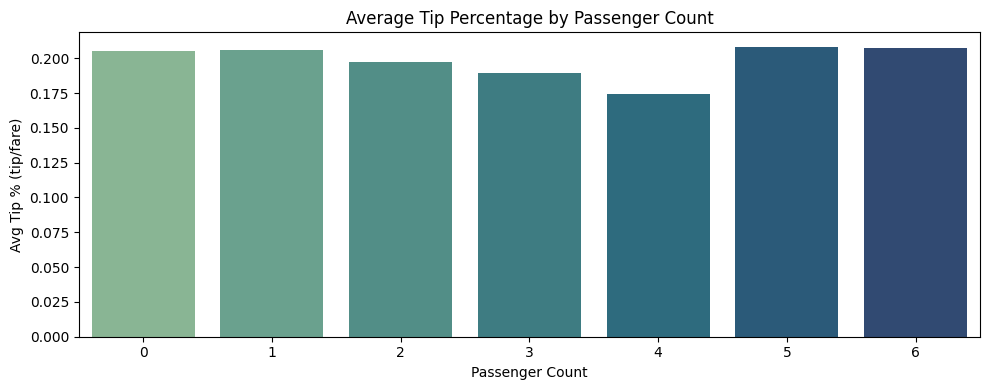

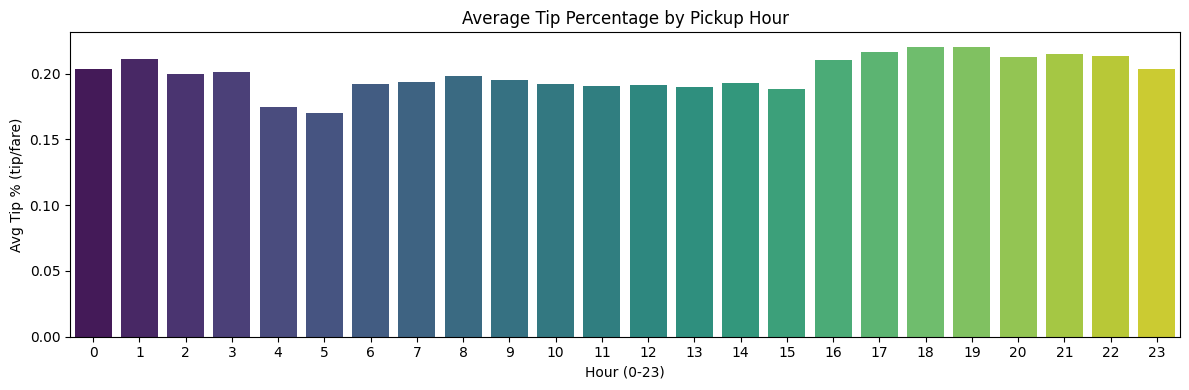

,pickup_hour,avg_tip_pct,trips
0,0,0.203629,8323
1,1,0.211328,5594
2,2,0.200134,3656
3,3,0.201669,2408
4,4,0.174502,1574
5,5,0.170263,1703
6,6,0.192011,4074
7,7,0.194027,8108
8,8,0.198304,11236
9,9,0.195063,12751


,distance_tier,avg_tip_pct,trips
0,<=2,0.22434,163612
1,2-5,0.18608,82216
2,>5,0.16478,51880


,passenger_count_clean,avg_tip_pct,trips
0,0,0.205318,4540
1,1,0.205870,226281
2,2,0.197267,43726
3,3,0.189255,10888
4,4,0.174000,5949
5,5,0.208218,3766
6,6,0.207250,2558


In [62]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Tip percentage analysis by distance tiers, passenger counts, and pickup hour

df_use = merged_zone_trip.copy()

tip_col = 'tip_amount'
fare_col = 'fare_amount'
dist_col = 'trip_distance'
dt_col = 'tpep_pickup_datetime'

# Parse datetime and filter valid rows
df_use[dt_col] = pd.to_datetime(df_use[dt_col], errors='coerce')
df_use = df_use.loc[df_use[dt_col].notna() & (df_use[fare_col] > 0) & (df_use[tip_col] >= 0) & (df_use[dist_col] > 0)]

# Features
df_use['tip_pct'] = df_use[tip_col] / df_use[fare_col]
df_use['pickup_hour'] = df_use[dt_col].dt.hour
passenger_col = 'passenger_count'
df_use['passenger_count_clean'] = pd.to_numeric(df_use[passenger_col], errors='coerce').fillna(0).astype(int)

# Distance tiers
bins = [0, 2, 5, np.inf]
labels = ['<=2', '2-5', '>5']
df_use['distance_tier'] = pd.cut(df_use[dist_col], bins=bins, labels=labels, right=True, include_lowest=True)
df_use['distance_tier'] = pd.Categorical(df_use['distance_tier'], categories=labels, ordered=True)

# Aggregations
dist_avg = (
    df_use.groupby('distance_tier', as_index=False)
    .agg(avg_tip_pct=('tip_pct', 'mean'), trips=('tip_pct', 'size'))
)
pc_avg = (
    df_use.groupby('passenger_count_clean', as_index=False)
    .agg(avg_tip_pct=('tip_pct', 'mean'), trips=('tip_pct', 'size'))
)
hour_avg = (
    df_use.groupby('pickup_hour', as_index=False)
    .agg(avg_tip_pct=('tip_pct', 'mean'), trips=('tip_pct', 'size'))
)

# Plots
plt.figure(figsize=(8, 4))
sns.barplot(data=dist_avg, x='distance_tier', y='avg_tip_pct', palette='magma')
plt.title('Average Tip Percentage by Distance Tier')
plt.xlabel('Distance Tier (miles)')
plt.ylabel('Avg Tip % (tip/fare)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=pc_avg.sort_values('passenger_count_clean'), x='passenger_count_clean', y='avg_tip_pct', palette='crest')
plt.title('Average Tip Percentage by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Avg Tip % (tip/fare)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
sns.barplot(data=hour_avg.sort_values('pickup_hour'), x='pickup_hour', y='avg_tip_pct', palette='viridis')
plt.title('Average Tip Percentage by Pickup Hour')
plt.xlabel('Hour (0-23)')
plt.ylabel('Avg Tip % (tip/fare)')
plt.tight_layout()
plt.show()

display(hour_avg.sort_values('pickup_hour'))
display(dist_avg)
display(pc_avg.sort_values('passenger_count_clean'))

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [63]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%


**3.2.14** <br>
Analyse the variation of passenger count across hours and days of the week.

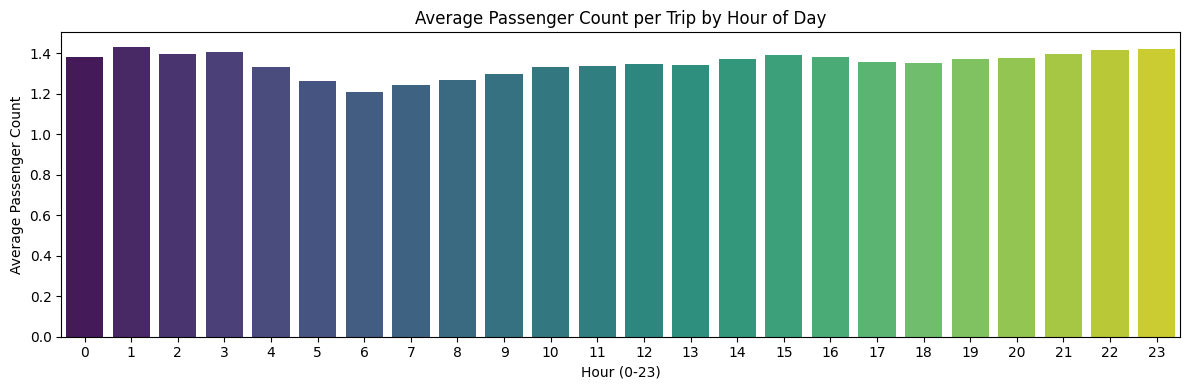

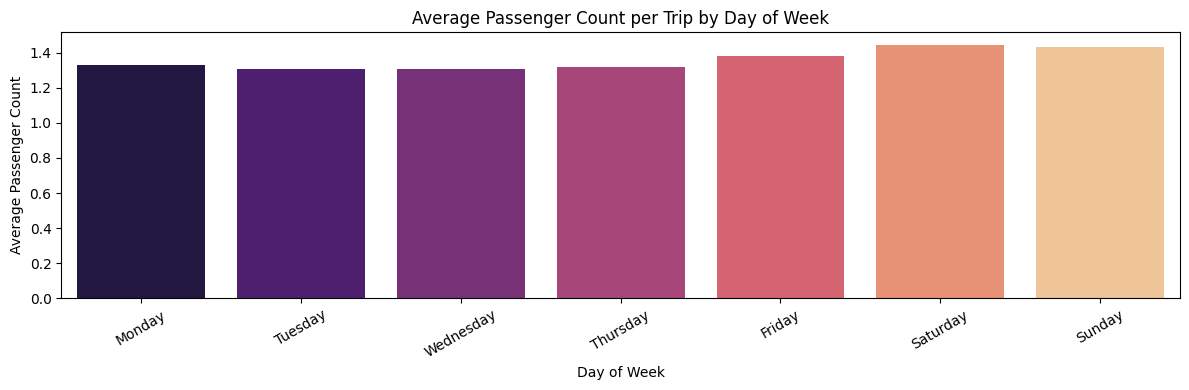

,pickup_hour,avg_passenger_count,trips
0,0,1.382168,8423
1,1,1.430739,5667
2,2,1.396988,3718
3,3,1.407347,2450
4,4,1.330037,1618
5,5,1.264434,1732
6,6,1.209053,4109
7,7,1.244425,8162
8,8,1.266543,11319
9,9,1.294534,12844


,day_of_week,avg_passenger_count,trips
0,Monday,1.330784,37396
1,Tuesday,1.306854,43493
2,Wednesday,1.306971,46089
3,Thursday,1.319445,47163
4,Friday,1.378513,44622
5,Saturday,1.443986,43632
6,Sunday,1.430541,37785


In [64]:
# See how passenger count varies across hours and days

df_use = merged_zone_trip.copy()

dt_col = 'tpep_pickup_datetime'
pc_col = 'passenger_count'

df_use['passenger_count_clean'] = pd.to_numeric(df_use[pc_col], errors='coerce')

# Filter valid rows
df_use = df_use.loc[ df_use[dt_col].notna() & df_use['passenger_count_clean'].notna() & (df_use['passenger_count_clean'] >= 0) ]

# Time features
df_use['pickup_hour'] = df_use[dt_col].dt.hour
df_use['day_of_week'] = df_use[dt_col].dt.day_name()
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_use['day_of_week'] = pd.Categorical(df_use['day_of_week'], categories=order_days, ordered=True)

# Aggregations
hourly_avg = (
    df_use.groupby('pickup_hour', as_index=False)['passenger_count_clean']
    .agg(avg_passenger_count='mean', trips='size')
)
dow_avg = (
    df_use.groupby('day_of_week', as_index=False)['passenger_count_clean']
    .agg(avg_passenger_count='mean', trips='size')
)

# Plots
plt.figure(figsize=(12, 4))
sns.barplot(data=hourly_avg.sort_values('pickup_hour'), x='pickup_hour', y='avg_passenger_count', palette='viridis')
plt.title('Average Passenger Count per Trip by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Average Passenger Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
sns.barplot(data=dow_avg.sort_values('day_of_week'), x='day_of_week', y='avg_passenger_count', palette='magma')
plt.title('Average Passenger Count per Trip by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Passenger Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Tabular outputs
display(hourly_avg.sort_values('pickup_hour'))
display(dow_avg.sort_values('day_of_week'))


**3.2.15**  <br>
Analyse the variation of passenger counts across zones

,Zone,pickup_total_pass,pickup_trips,pickup_avg_pass_per_trip,dropoff_total_pass,dropoff_trips,dropoff_avg_pass_per_trip,overall_total_passengers
151,Midtown Center,19047,13906,1.369697,16056,11737,1.367982,35103
226,Upper East Side South,18409,14063,1.309038,16590,12583,1.318446,34999
225,Upper East Side North,16831,12663,1.329148,17587,13387,1.313737,34418
119,JFK Airport,22980,15434,1.488921,5488,3558,1.54244,28468
219,Times Sq/Theatre District,14541,9910,1.467306,13803,9095,1.517647,28344
152,Midtown East,14200,10759,1.319825,11371,8576,1.32591,25571
132,Lincoln Square East,13268,9845,1.347689,11342,8501,1.334196,24610
160,Murray Hill,11739,8824,1.330349,11989,8904,1.346473,23728
176,Penn Station/Madison Sq West,13533,10140,1.334615,9206,6698,1.37444,22739
228,Upper West Side South,11209,8396,1.33504,11250,8319,1.352326,22459


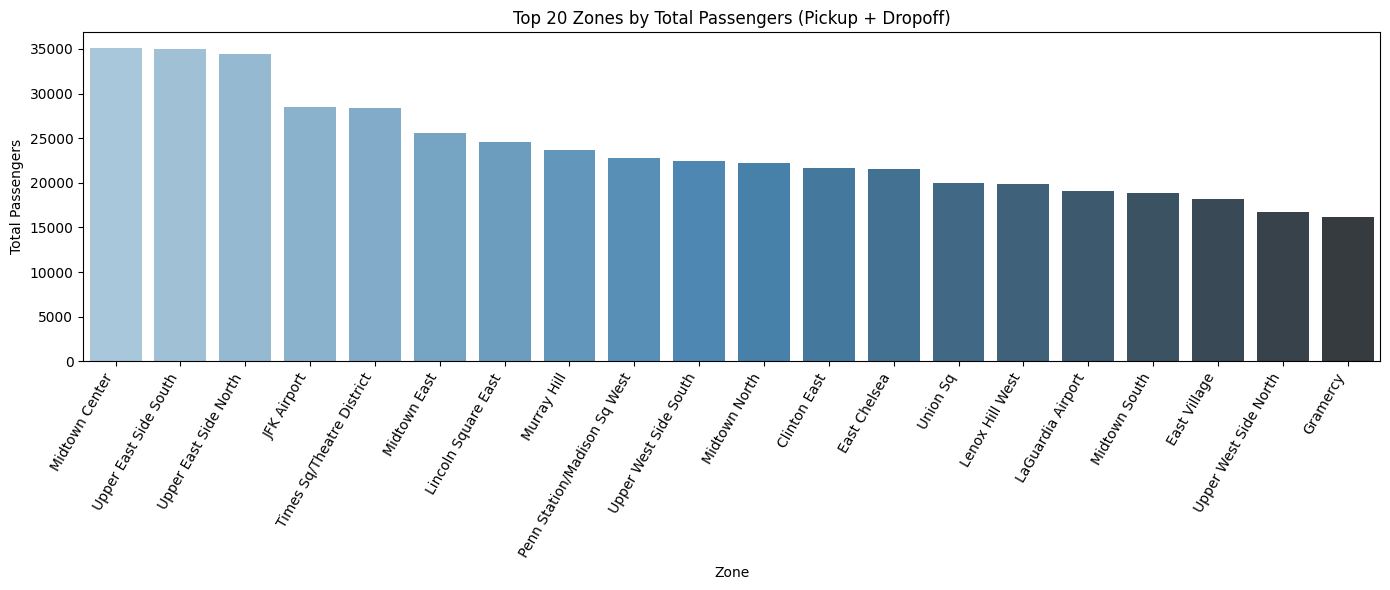

In [65]:
# How does passenger count vary across zones

df_use = merged_zone_trip.copy()

# Detect necessary trip columns
pu_col = 'PULocationID'
do_col = 'DOLocationID'
pc_col = 'passenger_count'
dt_col = 'tpep_pickup_datetime'

# Clean passenger count and datetime
df_use['passenger_count_clean'] = pd.to_numeric(df_use[pc_col], errors='coerce')
df_use = df_use.loc[df_use['passenger_count_clean'].notna() & (df_use['passenger_count_clean'] >= 0)]

zones_df = zones_with_trips.copy()

# Detect location id and zone name columns in zones_df
zone_id_col = 'LocationID'
zone_name_col = 'zone'

# Build mapping dict {LocationID: ZoneName}
zone_map = zones_df[[zone_id_col, zone_name_col]].dropna()
zone_map = zone_map.drop_duplicates(subset=[zone_id_col])
zone_lookup = dict(zip(zone_map[zone_id_col].astype(int), zone_map[zone_name_col].astype(str)))

# Map zone names for pickup and dropoff
df_use['PUZone'] = df_use[pu_col].map(lambda x: zone_lookup.get(int(x)) if pd.notna(x) else None)
df_use['DOZone'] = df_use[do_col].map(lambda x: zone_lookup.get(int(x)) if pd.notna(x) else None)

# Aggregate passenger counts by zones
pickup_zone_passengers = (
    df_use.groupby('PUZone', as_index=False)['passenger_count_clean']
    .agg(total_passengers='sum', trips='size', avg_passengers_per_trip='mean')
    .sort_values('total_passengers', ascending=False)
)
dropoff_zone_passengers = (
    df_use.groupby('DOZone', as_index=False)['passenger_count_clean']
    .agg(total_passengers='sum', trips='size', avg_passengers_per_trip='mean')
    .sort_values('total_passengers', ascending=False)
)

# Combined view: align pickup and dropoff by zone name
combined = pd.merge(
    pickup_zone_passengers.rename(columns={
        'PUZone': 'Zone',
        'total_passengers': 'pickup_total_pass',
        'trips': 'pickup_trips',
        'avg_passengers_per_trip': 'pickup_avg_pass_per_trip'
    }),
    dropoff_zone_passengers.rename(columns={
        'DOZone': 'Zone',
        'total_passengers': 'dropoff_total_pass',
        'trips': 'dropoff_trips',
        'avg_passengers_per_trip': 'dropoff_avg_pass_per_trip'
    }),
    on='Zone',
    how='outer'
).fillna(0)

combined['overall_total_passengers'] = combined['pickup_total_pass'] + combined['dropoff_total_pass']
combined = combined.sort_values('overall_total_passengers', ascending=False)

# Display top zones tables
display(combined.head(10))

# Top 20 zones by total passengers (pickup + dropoff)
topN = 20
top_combined = combined.head(topN).copy()
plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_combined,
    x='Zone',
    y='overall_total_passengers',
    palette='Blues_d'
)
plt.title(f'Top {topN} Zones by Total Passengers (Pickup + Dropoff)')
plt.xlabel('Zone')
plt.ylabel('Total Passengers')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Add average passenger count per zone to zones_with_trips GeoDataFrame

# Build zones_with_trips from trips + zones, then add avg passenger count per zone


print("Found shapefile:", taxi_zones_path.resolve())

trips = merged_zone_trip.copy()

# Helper to find columns robustly (case-insensitive, underscore-insensitive)
def _find_col(df, candidates):
    lc_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in lc_map:
            return lc_map[cand]
    for c in df.columns:
        if any(c.lower().replace('_','') == cand.replace('_','') for cand in candidates):
            return c
    return None

# Detect trip columns
pu_col = 'PULocationID'
pc_col = 'passenger_count'
dt_col = 'tpep_pickup_datetime'

# Clean trips data
trips['passenger_count_clean'] = pd.to_numeric(trips[pc_col], errors='coerce')
trips = trips.loc[trips['passenger_count_clean'].notna() & (trips['passenger_count_clean'] >= 0)]

# Read taxi zones shapefile as GeoDataFrame
zones_gdf = gpd.read_file(taxi_zones_path)

# Detect zone id and name columns in shapefile
zone_id_col = 'LocationID'
zone_name_col = 'zone'

# Compute average passenger count and trip counts per pickup zone (compatible with older pandas)
grp = trips.groupby(pu_col)['passenger_count_clean']
avg_passengers_by_zone = grp.agg(['mean', 'size']).reset_index()
avg_passengers_by_zone = avg_passengers_by_zone.rename(columns={'mean': 'avg_passenger_count', 'size': 'trips'})

# Ensure key types align for merge
avg_passengers_by_zone[pu_col] = pd.to_numeric(avg_passengers_by_zone[pu_col], errors='coerce').astype('Int64')
zones_gdf[zone_id_col] = pd.to_numeric(zones_gdf[zone_id_col], errors='coerce').astype('Int64')

# Merge into zones_gdf -> zones_with_trips
zones_with_trips = zones_gdf.merge(
    avg_passengers_by_zone.rename(columns={pu_col: zone_id_col}),
    on=zone_id_col,
    how='left'
)

# Fill missing stats with 0 (zones with no trips in sample)
zones_with_trips['avg_passenger_count'] = zones_with_trips['avg_passenger_count'].fillna(0.0)
zones_with_trips['trips'] = zones_with_trips['trips'].fillna(0).astype(int)

# show top zones by avg passenger count
top_avg = zones_with_trips.sort_values('avg_passenger_count', ascending=False)[[zone_name_col, 'avg_passenger_count', 'trips']].head(20)
display(top_avg)

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

surcharge,trips_applied,total_trips,prevalence
improvement_surcharge,300162,300180,0.999940
mta_tax,297577,300180,0.991329
congestion_surcharge,278351,300180,0.927280
extra,182135,300180,0.606753
tolls_amount,24203,300180,0.080628


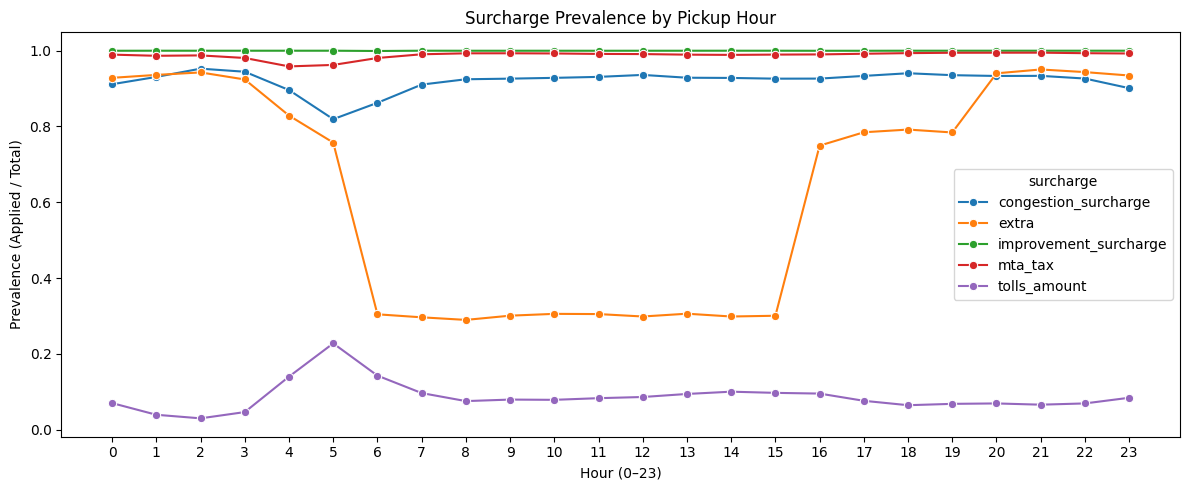

In [67]:
# How often is each surcharge applied?

# Surcharge prevalence: by hour

df_use = merged_zone_trip.copy()

surcharge_cols = [ 'mta_tax','improvement_surcharge','congestion_surcharge','tolls_amount','extra' ]

dt_col = 'tpep_pickup_datetime'
pu_col = 'PULocationID'
do_col = 'DOLocationID'

df_use['pickup_hour'] = df_use[dt_col].dt.hour

zone_lookup = dict(zip(zones_with_trips['LocationID'],zones_with_trips['zone']))

df_use['PUZone'] = df_use[pu_col].map(zone_lookup)
df_use['DOZone'] = df_use[do_col].map(zone_lookup)

# Applied flags (>0 means applied)
for col in surcharge_cols:
    df_use[col + '_applied'] = df_use[col].fillna(0) > 0

# Overall prevalence
total_trips = len(df_use)

overall_df = pd.DataFrame([
    {
        'surcharge': col,
        'trips_applied': int(df_use[col + '_applied'].sum()),
        'total_trips': total_trips,
        'prevalence': df_use[col + '_applied'].mean()
    }
    for col in surcharge_cols
]).sort_values('prevalence', ascending=False)


# Prevalence by pickup hour
hourly_df = pd.concat(
    [
        df_use
        .groupby('pickup_hour')[col + '_applied']
        .agg(trips_applied='sum', total_trips='size')
        .assign(
            surcharge=col,
            prevalence=lambda x: x['trips_applied'] / x['total_trips']
        )
        .reset_index()
        for col in surcharge_cols
    ],
    ignore_index=True
)

display(overall_df.style.hide(axis="index"))


# line plot Hourly prevalence
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=hourly_df.sort_values(['surcharge', 'pickup_hour']),
    x='pickup_hour',
    y='prevalence',
    hue='surcharge',
    marker='o'
)
plt.title('Surcharge Prevalence by Pickup Hour')
plt.xlabel('Hour (0–23)')
plt.ylabel('Prevalence (Applied / Total)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()


## **4** Conclusion
 <br>

### **4.1** Final Insights and Recommendations
<br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

<br>

Summary

Busiest Hours: Clear commuter peaks on weekdays (morning/evening), weekend peaks shift later with flatter midday demand.
Busiest Days/Months: Fridays and weekends lead trips, seasonal peak in summer with post-peak softening.
Busiest Zones: Central Manhattan corridors (Midtown, Lower Manhattan) and airport zones (JFK, LGA) dominate pickups and dropoffs, including night hours.

Revenue & Pricing

Night vs Day: Nighttime revenue is a smaller but material share, late-night hotspots cluster around entertainment districts and airports.
Fare Drivers: Fare scales strongly with distance and moderately with duration, passenger count has weak impact.
Vendor/Tier Effects: Fare-per-mile varies by vendor and distance tier, shorter trips (≤2 miles) show higher per-mile rates due to base fees.

Customer Experience

Tips: Tip percentage rises modestly with distance, low tips more prevalent at certain late-night hours and shorter rides.
Surcharges: Congestion and airport fees concentrate by zone and hour (Manhattan, airport corridors), tolls vary by route selection.

Routing & Bottlenecks

Slow Routes: Specific PU to DO corridors exhibit low speeds during peak hours, speeds improve off-peak. Pre-commute staging reduces delays.
Night Traffic: 23:00-05:59 has distinct top zones, optimize late-night coverage with fewer zones but deeper presence.

Geography

Choropleth Insights: Trip volumes cluster around transit hubs, business districts, and connectors, peripheral zones show lower intensity.
Zone Mix: Several zones have high solo rider share, others skew to group travel (higher average passenger counts).

Recommendations

Supply Allocation: Increase driver availability in weekday commute windows and shift supply later on weekends, stage drivers in Midtown, Financial District, and airports before peaks.
Dynamic Pricing: Tune surge thresholds by hour/day and zone, lower thresholds during predictable peaks to improve reliability, relax during quiet hours to sustain utilization.
Dispatch & Repositioning: Real-time repositioning toward emerging hotspots, pre-commute staging reduces empty miles and improves match rates.
Route Optimization: Prefer faster corridors during identified slow-hour windows, guide drivers to avoid known bottlenecks (signal-heavy avenues, construction zones) using zone-level speed metrics.
Night Operations: Focus coverage on top late-night pickup/dropoff zones, add micro‑hubs and safe, well-lit pickup points to reduce cancellations and wait times.
Vendor Strategy: For short trips, consider fee transparency and incentives to mitigate higher per-mile base effects, benchmark vendors’ fare-per-mile by tier to align quality and pricing.
Surcharge Awareness: Communicate surcharge expectations in high-incidence zones/hours, consider routing alternatives to minimize tolls when ETAs are comparable.
Tip Uplift: Encourage tipping via UX prompts after longer trips and at hours with historically higher tips, address low-tip cohorts (short rides, certain hours) with service cues and driver guidance.
Staffing & Maintenance: Schedule maintenance/training during quiet hours, use driver incentives to cover late-night peaks and early-morning gaps.
Forecasting & SLAs: Set hour-by-hour SLAs (ETAs, acceptance rates) per zone, integrate seasonal effects and event calendars for proactive staffing.


**4.1.2**  <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

<font color = red>[Answer]</font> <br>

Core Positioning

Peak Corridors: Stage cabs pre-peak in Midtown East/West, Lower Manhattan, and Financial District, maintain rolling buffers near Penn Station, Grand Central, and major hotel clusters.
Airport Hubs: Keep dedicated pools at JFK/LGA with dynamic spillover to nearby zones, increase late-night presence for flight banks and early-morning departures.
Nightlife Anchors: From 22:00-02:00, position near entertainment districts (West Village, Lower East Side, Williamsburg connectors) and transit transfer points.
Event-Driven Zones: Add flexible capacity near stadiums/convention centers on event calendars, deploy 60-90 minutes pre-end to absorb exit surges.

Temporal Tactics

Weekday Commute: 07-10 and 16-19 - pre-stage in business districts and major transit nodes, prioritize fast-merge corridors identified with higher throughput.
Weekend Shift: 11-15 and 20-01 - pivot toward shopping/entertainment zones, reduce early-morning coverage except airport rings.
Shoulder Hours: 05-07 and 21-23 - thinner spread with micro-hubs at multi-line subway stations, rebalance toward emerging hotspots via live heatmaps.

Micro-Hubs & Routing

Micro-Hubs: Define safe, high-visibility pickup spots per busy zone to cut cancellations, rotate cabs through hubs to minimize idle clustering.
Fast Corridors: Use speed audit insights to favor quicker east–west/avenue combinations at peak, avoid historically slow streets under construction or signal-heavy segments.
Toll-Aware Paths: Where ETAs are comparable, pick lower-toll routes for price-sensitive corridors, keep high-reliability toll routes for tight SLAs.

Supply Controls

Tiered Buffers: Maintain minimum cab counts per top-10 pickup zones, add overflow pool that repositions based on real-time demand spikes.
Dynamic Reposition: Every 15–30 minutes, pull 10–15% of idle cabs from quiet zones into adjacent growing hotspots, use contiguous-zone flows to reduce empty miles.
Driver Shifts: Align shifts to peaks (weekday commute, weekend late-night) and seasonality, schedule maintenance/training in quiet windows.

Pricing & Incentives

Surge Guardrails: Calibrate by hour/day/zone to smooth demand-supply gaps without over-suppressing trips, lower thresholds in predictable peaks, relax off-peak.
Incentives: Offer short bonuses for coverage gaps (late-night airport returns, early-morning city entries), reward adherence to hub placements in peak windows.

**4.1.3** <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

<font color = red>[Answer]</font> <br>

Time-Based Tiers:
Peak Weekday Commute (07-10, 16-19): Slightly lower surge thresholds in top zones to maintain reliability, cap max multiplier to protect competitiveness, use micro surges in adjacent zones to preposition supply.
Weekend Late Peak (20-01): Allow modest surges in nightlife corridors, pair with driver incentives to ensure coverage and stabilize ETAs.

Zone-Aware Pricing:
Airport Corridors: Transparent airport fee messaging, moderate surge near flight banks, offer bundled fixed-fare options for common airport routes to reduce price anxiety and boost conversion.
High-Congestion Zones (Manhattan core): Consider small congestion add-ons with ETA guarantees, offer alternative routing discounts for comparable travel times on lower-toll paths.

Distance Tier Optimization:
Short Trips (≤2 miles): Base-fee weight drives high per mile costs, introduce “short-hop” discount window during quiet hours to stimulate demand and improve utilization.
Mid Trips (2–5 miles): Keep standard per mile, test small dynamic adjustments by hour to smooth demand.
Long Trips (>5 miles): Volume discounts on per mile beyond a threshold, maintain consistent minimums to avoid under pricing on very long trips.

Vendor Benchmarking:
Monitor competitor fare-per-mile by tier and hour, set competitive guardrails (e.g., within 5-10% in top corridors). If your vendor shows higher short-trip per mile, offset via promo codes or loyalty accruals for frequent short rides.

Surcharge Hygiene:
Clearly itemize surcharges in high-incidence zones/hours (congestion, airport), minimize surprises. Where tolls add little ETA benefit, default to lower-toll routes, keep premium toll routes for SLA-critical trips with explicit user opt-in.